# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import random
import time
from math import sqrt

In [2]:
sns.set(rc={"figure.dpi": 200, 'savefig.dpi': 200})

# Pomocnicze funkcje

## Obliczenia

### Budowanie macierzy wypełnionej zgodnie ze wzorem

#### Macierz kwadratowa

In [3]:
def create_matrix(fn, n, m, dtype=np.float64):
    A = np.empty((n, m), dtype)
    
    for i in range(n):
        for j in range(m):
            A[i, j] = fn(i + 1, j + 1)
            
    return A

### Tworzenie wektorów

#### Tworzenie wektora wypełnionego wartościami zgodnie z zadaną funkcją

In [4]:
def create_vector(fn, n, dtype=np.float64):
    return np.array([fn(i) for i in range(n)], dtype)

### Pomiar czasu wykonywania kodu

#### Dekorator, pozwalający na pomiar czasu wykonania kodu

In [5]:
def print_duration(sec):
    t = int(sec)
    ms = int((sec - t) * 1000)
    s = t % 60
    t //= 60
    m = t % 60
    t //= 60
    print(f'Łączny czas wykonania: {t:>02}:{m:>02}:{s:>02}.{ms:<03}')

def timed(*, save_fn=None, save_dict=None):
    def decorator(fn):
        def inner(*args, **kwargs):
            start_time = time.perf_counter()
            res = fn(*args, **kwargs)
            duration = time.perf_counter() - start_time
    
            if save_dict is not None and save_fn: 
                save_dict[save_fn(*args, **kwargs)] = duration
            return res
        
        return inner
    return decorator

## Tworzenie wykresów

### Tworzenie wykresu *Heatmap*

In [6]:
def show_heatmap(df, annot=True, norm=None, xlabel='x', ylabel='y', title='', **kwargs):
    ax = plt.figure(figsize=(15, 10))
    s = sns.heatmap(df, cmap="YlGnBu", annot=annot, norm=norm, mask=df.isnull(), **kwargs)
    s.set_xlabel(xlabel, fontsize=16)
    s.set_ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=20, y=1.025)
    plt.show()

# Wstęp

Dany jest układ równań liniowych $Ax=b$. 

Elementy macierzy $A$ są zadane wzorem ($m,k$ - parametry zadania podane indywidualnie):

$
\begin{cases} 
    a_{i, i} = k \\ 
    a_{i, j} = (-1)^j \frac{m}{j} & dla & j > 1 \\
    a_{i, i-1} = \frac{m}{i} \\
    a_{i, j} = 0 & dla & j < i - 1 \\
\end{cases}
$

gdzie $k=11, m=2$

Przyjmij wektor $x$ jako dowolną n-elementową permutację ze zbioru $\{1, -1\}$ i oblicz wektor $b$. 

## Implementacja funkcji wyznaczającej elementy macierzy

In [7]:
k = 11
m = 2

def fn(i, j):
    if i == j: return k
    if j > i: return (-1)**j * m / j
    if j == i - 1: return m / i
    return 0

## Tworzenie macierzy $A$

Poniższa funkcja ma jedynie na celu ułatwienie tworzenia macierzy $A$ (żeby za każdym razem nie trzeba było przekazywać wszystkich parametrów).

In [8]:
create_A_matrix = lambda n, dtype=np.float64: create_matrix(fn, n, n, dtype)

###### Testy

In [9]:
create_A_matrix(5)

array([[11.        ,  1.        , -0.66666667,  0.5       , -0.4       ],
       [ 1.        , 11.        , -0.66666667,  0.5       , -0.4       ],
       [ 0.        ,  0.66666667, 11.        ,  0.5       , -0.4       ],
       [ 0.        ,  0.        ,  0.5       , 11.        , -0.4       ],
       [ 0.        ,  0.        ,  0.        ,  0.4       , 11.        ]])

## Wyznaczanie wektora $x$

Ponieważ, jako wektor $x$, będący rozwiązaniem układu równań $Ax=b$, możemy przyjąć wektor o współrzędnych, będących dowolną $n$-elementową permutacją liczb ze zbioru $\{-1, 1\}$, przyjmuję, że wektor $x$ będzie postaci $[-1, 1, -1, 1, ...]$ (na przemian będą występowały liczby $-1$ oraz $1$, rozpoczynając się od $-1$)

In [10]:
create_x_vector = lambda n, dtype=np.float64: create_vector(lambda i: (-1)**(i + 1), n, dtype)

###### Test

In [11]:
create_x_vector(5)

array([-1.,  1., -1.,  1., -1.])

## Obliczanie wektora $b$

Ponieważ nie znamy wektora $b$, w celu jego obliczenia dla danego $n$, konieczne jest najpierw wyznaczenie wektora $x$, który ma być rozwiązaniem układu równań. Następnie, korzystając z tego wektora, należy obliczyć wektor $b$. W późniejszych obliczeniach będziemy ten wektor wykorzystywać wraz z macierzą $A$ do obliczenia wektora $x$, po czym, porównamy wartość obliczonego w ten sposób wektora $x$ z wartością wektora $x$ wcześniej przyjętego jako rozwiązanie układu.

In [12]:
n = 5
A = create_A_matrix(n)
x_solution = create_x_vector(n, A.dtype)
b = A @ x_solution
b

array([ -8.43333333,  11.56666667,  -9.43333333,  10.9       ,
       -10.6       ])

# Zadanie 1

## Opis zadania

Metodą Jacobiego rozwiąż układ równań liniowych $Ax=b$ (przyjmując jako niewiadomą wektor $x$), 
przyjmując kolejno kryterium stopu: 

- $||x^{(i+1)} - x^{(i)}|| < \rho$

- $||Ax^{(i)} - b|| < \rho$

Obliczenia wykonaj dla różnych rozmiarów układu $n$, dla różnych wektorów początkowych, a także 
różnych wartości $\rho$ w kryteriach stopu. (*Podaj, jak liczono normę.*) Wyznacz liczbę iteracji oraz 
sprawdź różnicę w czasie obliczeń dla obu kryteriów stopu. 
Sprawdź dokładność obliczeń. 

## Kryteria stopu

### Sposób obliczania normy

Przy obliczaniu kryteriów stopu, wykorzystałem normę euklidesową. Skorzystałem z funkcji `linalg.norm` z biblioteki `numpy`, która domyślnie oblicza normę euklidesową. Wzór, opisujący sposób obliczania normy euklidesowej, ma postać:

$||x|| = \sqrt{\sum_{i}^{n} x_i^2}$

### Kryteria

#### Dekorator, ułatwiający korzystanie z kryteriów

In [13]:
def apply_function_args(fn):
    def inner(**kwargs):
        arg_names = fn.__code__.co_varnames
        return fn(**{k: kwargs[k] for k in arg_names})
    return inner

#### 1. Kryterium

$||x^{(i+1)} - x^{(i)}|| < \rho$

In [14]:
@apply_function_args
def progressive_difference(x_curr, x_next, 𝜌):
    return np.linalg.norm(x_next - x_curr) < 𝜌

###### Test

In [15]:
progressive_difference(
    foo=12412312,  # @apply_function_args decorator ensures that redundant parameters will be filtered out
    x_curr=np.array([3, 3, 3]),
    x_next=np.array([1, 1, 1]),
    𝜌=5.1
)

True

#### 2. Kryterium

$||Ax^{(i)} - b|| < \rho$

In [16]:
@apply_function_args
def solution_difference(x_curr, A, b, 𝜌):
    return np.linalg.norm(A @ x_curr - b) < 𝜌

###### Test

In [17]:
solution_difference(
    x_curr=np.array([3, 3, 3]),
    A=np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
    b=np.array([1, 1, 1]),
    𝜌=123
)

True

## Wyznaczanie błędów obliczeń

### Norma maksimum

Do wyznaczania błędów ponownie wykorzystałem normę euklidesową.

In [18]:
max_err = lambda x1, x2: np.linalg.norm(x1 - x2)

###### Test

In [19]:
max_err(np.array([2, 2, 2]), np.array([1, 1, 1]))

1.7320508075688772

## Metoda Jacobiego

Umieszczony poniżej słownik służy do zapisywania czasów wykonywanych obliczeń.

In [20]:
times = {}

### Implementacja

In [21]:
@timed(
    save_fn=lambda A, *args, **kwargs: len(A),
    save_dict=times
)
def jacobi(A, b, start_vector, *, stop_criterion=progressive_difference, 𝜌=1e-6, dtype=np.float64, max_iters=1000):
    n = len(A)
    D = np.diag(A)
    R = A - np.diagflat(D)
    x_curr = start_vector
    iters = 0
    
    while iters < max_iters:
        x_next = (b - (R @ x_curr)) / D
        iters += 1
        if stop_criterion(A=A, b=b, x_next=x_next, x_curr=x_curr, 𝜌=𝜌): break
        x_curr = x_next
    else:
        iters = -1
        
    return x_next, iters

###### Testy

Jak możemy zauważyć, wybór wektora początkowego ma znikome znaczenie

In [22]:
n = 10
A = create_A_matrix(n)
x_solution = create_x_vector(n)
b = A @ x_solution
x_start = np.array([0] * n)

x, iters = jacobi(A, b, x_start, stop_criterion=solution_difference)
x_start, x, iters

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([-0.99999999,  1.        , -1.        ,  1.        , -1.        ,
         1.        , -1.        ,  1.        , -1.        ,  1.        ]),
 8)

## Rozwiązanie

In [23]:
times.clear()

### Pomocnicza funkcja

In [24]:
@timed(
    save_fn=lambda *args, **kwargs: 'total',
    save_dict=times
)
def calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion, dtype=np.float64, max_iters=1000, log_every=25):
    results = {}
    
    vectors = [[None] * len(𝜌_list) for _ in range(len(n_list))]  # Calculated vectors
    errors = np.empty((len(n_list), len(𝜌_list)), dtype)
    iters = np.empty((len(n_list), len(𝜌_list)), int)
    times_ = np.empty((len(n_list), len(𝜌_list)), dtype)
    
    for i, n in enumerate(n_list):
        A = create_A_matrix(n, dtype)
        x_start = create_vector(start_vector_fn, n)  # Initial x vector
        x_solution = create_x_vector(n, dtype)  # Expected solution
        b = A @ x_solution

        for j, 𝜌 in enumerate(𝜌_list):
            x, it = jacobi(A, b, x_start, stop_criterion=stop_criterion, 𝜌=𝜌, dtype=dtype, max_iters=max_iters)
            if it >= 0:
                vectors[i][j] = x
                errors[i, j] = max_err(x, x_solution)
                iters[i, j] = it
                times_[i, j] = times[n]
            else:
                vectors[i][j] = np.nan
                errors[i, j] = np.nan
                iters[i, j] = -1
                times_[i, j] = np.nan
            
        if not (i + 1) % log_every:
            print(f'Obliczono układy równań dla {i + 1} wartości n')
            
    if (i + 1) % log_every:
        print(f'Obliczono układy równań dla {i + 1} wartości n')
        
    # Save results
    for key, data in zip(
        ('vectors', 'errors', 'iters', 'times'), 
        (vectors, errors, iters, times_)
    ):
        results[key] = pd.DataFrame(data, index=n_list, columns=𝜌_list)
            
    return results

###### Testy

In [25]:
n_list = [10, 25, 100]
start_vector_fn = lambda i: random.randint(-10e10, 10e10)
𝜌_list = [
    1e-5,
    1e-10,
    1e-15
]
stop_criterion = progressive_difference

results = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)

Obliczono układy równań dla 3 wartości n


In [26]:
results['iters']

,1.000000e-05,1.000000e-10,1.000000e-15
10,17,21,26
25,16,21,26
100,17,21,26


In [27]:
results['errors']

,1.000000e-05,1.000000e-10,1.000000e-15
10,1.096288e-07,7.480548e-12,3.330669e-16
25,1.007402e-06,6.230174e-12,5.874748e-16
100,1.048147e-07,7.141809e-12,1.518207e-15


In [28]:
results['times']

,1.000000e-05,1.000000e-10,1.000000e-15
10,0.000375,0.000343,0.000542
25,0.000744,0.000500,0.000556
100,0.003046,0.003185,0.004325


In [29]:
results['vectors']

,1.000000e-05,1.000000e-10,1.000000e-15
10,"[-1.0000000874757546, 1.0000000457215035, -1.0...","[-1.0000000000059766, 1.0000000000031208, -1.0...","[-1.0, 1.0000000000000002, -1.0, 1.0, -1.0, 1...."
25,"[-0.9999991966793664, 0.999999585526437, -0.99...","[-0.9999999999950205, 0.9999999999974182, -0.9...","[-1.0000000000000002, 1.0, -1.0, 1.0, -1.00000..."
100,"[-0.9999999159490087, 0.9999999569890083, -0.9...","[-0.9999999999942961, 0.9999999999970256, -0.9...","[-1.0000000000000002, 0.9999999999999999, -1.0..."


### Dla ustalonego wektora początkowego oraz różnych $n$ i różnych $\rho$

W poniższych obliczeniach, jako wektor początkowy, przyjmuję wektor $n$-elementowy złożony z samych zer.

#### Dla 1. kryterium stopu

In [30]:
n_list = list(range(2, 501))
start_vector_fn = lambda _: 0
𝜌_list = [
    1e-1,
    1e-2,
    1e-3,
    1e-5,
    1e-10,
    1e-15
]
stop_criterion = progressive_difference

results1 = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 100 wartości n
Obliczono układy równań dla 125 wartości n
Obliczono układy równań dla 150 wartości n
Obliczono układy równań dla 175 wartości n
Obliczono układy równań dla 200 wartości n
Obliczono układy równań dla 225 wartości n
Obliczono układy równań dla 250 wartości n
Obliczono układy równań dla 275 wartości n
Obliczono układy równań dla 300 wartości n
Obliczono układy równań dla 325 wartości n
Obliczono układy równań dla 350 wartości n
Obliczono układy równań dla 375 wartości n
Obliczono układy równań dla 400 wartości n
Obliczono układy równań dla 425 wartości n
Obliczono układy równań dla 450 wartości n
Obliczono układy równań dla 475 wartości n
Obliczono układy równań dla 499 wartości n
Łączny czas wykonania: 00:00:25.291


##### Liczby iteracji

Widzimy, że liczba iteracji prawie się nie zmienia, podczas zwiększania $n$, natomiast, zmniejszanie wartości $\rho$ dość znacząco wpływa na wzrost liczby iteracji.

In [31]:
df_iters1 = results1['iters']
df_iters1

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,3,4,4,6,11,16
3,3,4,5,6,11,16
4,3,4,5,6,11,16
5,3,4,5,6,11,16
6,3,4,5,6,11,16
...,...,...,...,...,...,...
496,4,4,5,7,11,16
497,4,4,5,7,11,16
498,4,4,5,7,11,16
499,4,4,5,7,11,16


In [32]:
min_n = 2
interval = 15
ns = [0, *range(interval - min_n, len(df_iters1), interval)]
if ns[-1] != len(df_iters1): ns.append(len(df_iters1) - 1)
df_iters1_part = df_iters1.iloc[ns]
df_iters1_part.to_excel('zad1-iters1-part.xlsx')
df_iters1_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,3,4,4,6,11,16
15,3,4,5,6,11,16
30,3,4,5,6,11,16
45,3,4,5,7,11,16
60,3,4,5,7,11,16
75,3,4,5,7,11,16
90,3,4,5,7,11,16
105,3,4,5,7,11,16
120,3,4,5,7,11,16
135,3,4,5,7,11,16


Bardzo dobrze pokazuje to poniższy wykres.

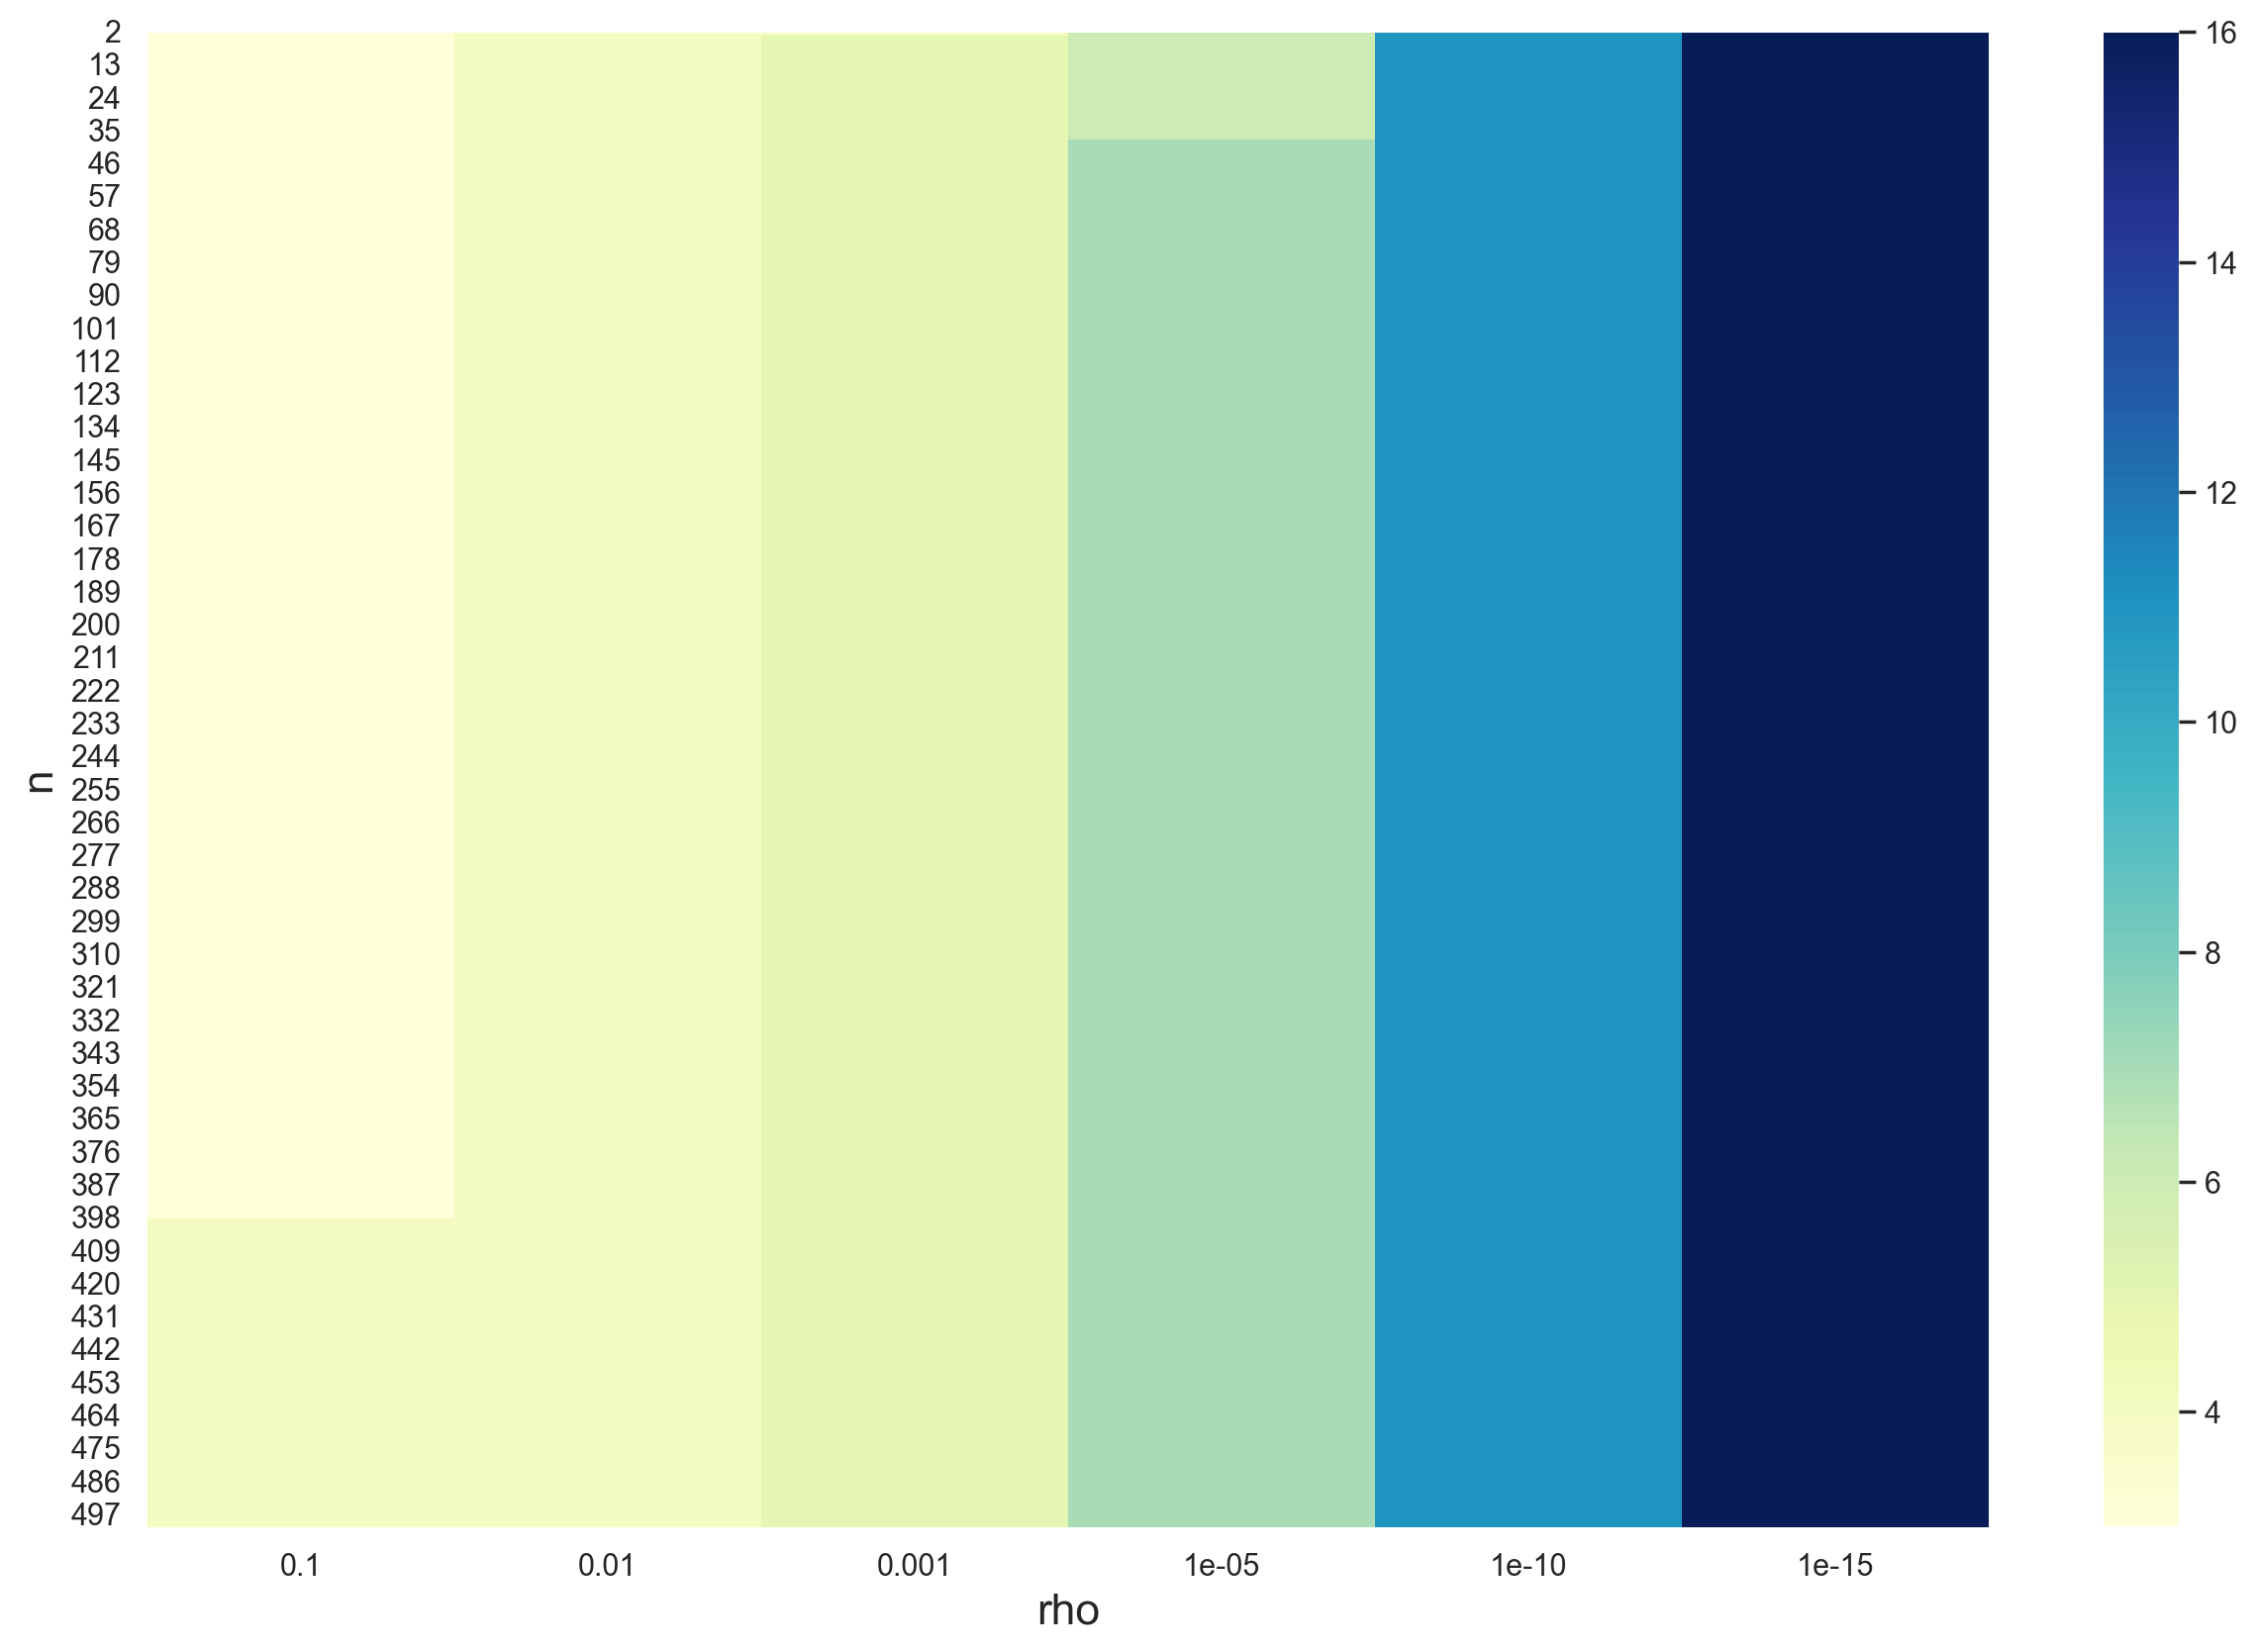

In [33]:
show_heatmap(df_iters1, xlabel='rho', ylabel='n', annot=False)

##### Czasy obliczeń

W tym przypadku widzimy, że czas obliczeń zwiększa się zarówno podczas zwiększania wartości $n$, jak i podczas zmniejszania wartości $\rho$.

In [34]:
df_times1 = results1['times']
df_times1

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000138,0.000084,0.000079,0.000104,0.000235,0.000525
3,0.000103,0.000085,0.000100,0.000109,0.000186,0.000248
4,0.000075,0.000084,0.000096,0.000113,0.000184,0.000249
5,0.000073,0.000083,0.000096,0.000110,0.000179,0.000253
6,0.000192,0.000100,0.000095,0.000165,0.000388,0.000530
...,...,...,...,...,...,...
496,0.002053,0.002184,0.002729,0.002879,0.003700,0.003347
497,0.002637,0.002046,0.002430,0.002671,0.002703,0.004403
498,0.002362,0.002156,0.002406,0.002826,0.003198,0.004212
499,0.002311,0.002064,0.002281,0.003056,0.002712,0.004403


In [35]:
df_times1_part = df_times1.iloc[ns]
df_times1_part.to_excel('zad1-times1-part.xlsx')
df_times1_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000138,0.000084,0.000079,0.000104,0.000235,0.000525
15,0.000074,0.000066,0.000079,0.000085,0.000140,0.000197
30,0.000125,0.000065,0.000074,0.000091,0.000136,0.000186
45,0.000064,0.000073,0.000075,0.000098,0.000140,0.000189
60,0.000137,0.000067,0.000093,0.000105,0.000132,0.000196
75,0.000096,0.000069,0.000077,0.000098,0.000159,0.000198
90,0.000115,0.000072,0.000082,0.000117,0.000157,0.000214
105,0.000409,0.000459,0.000619,0.000747,0.001336,0.001853
120,0.000480,0.000430,0.000523,0.000760,0.001155,0.002028
135,0.000587,0.000671,0.000633,0.000983,0.001411,0.001687


###### Wykres czasów w skali liniowej

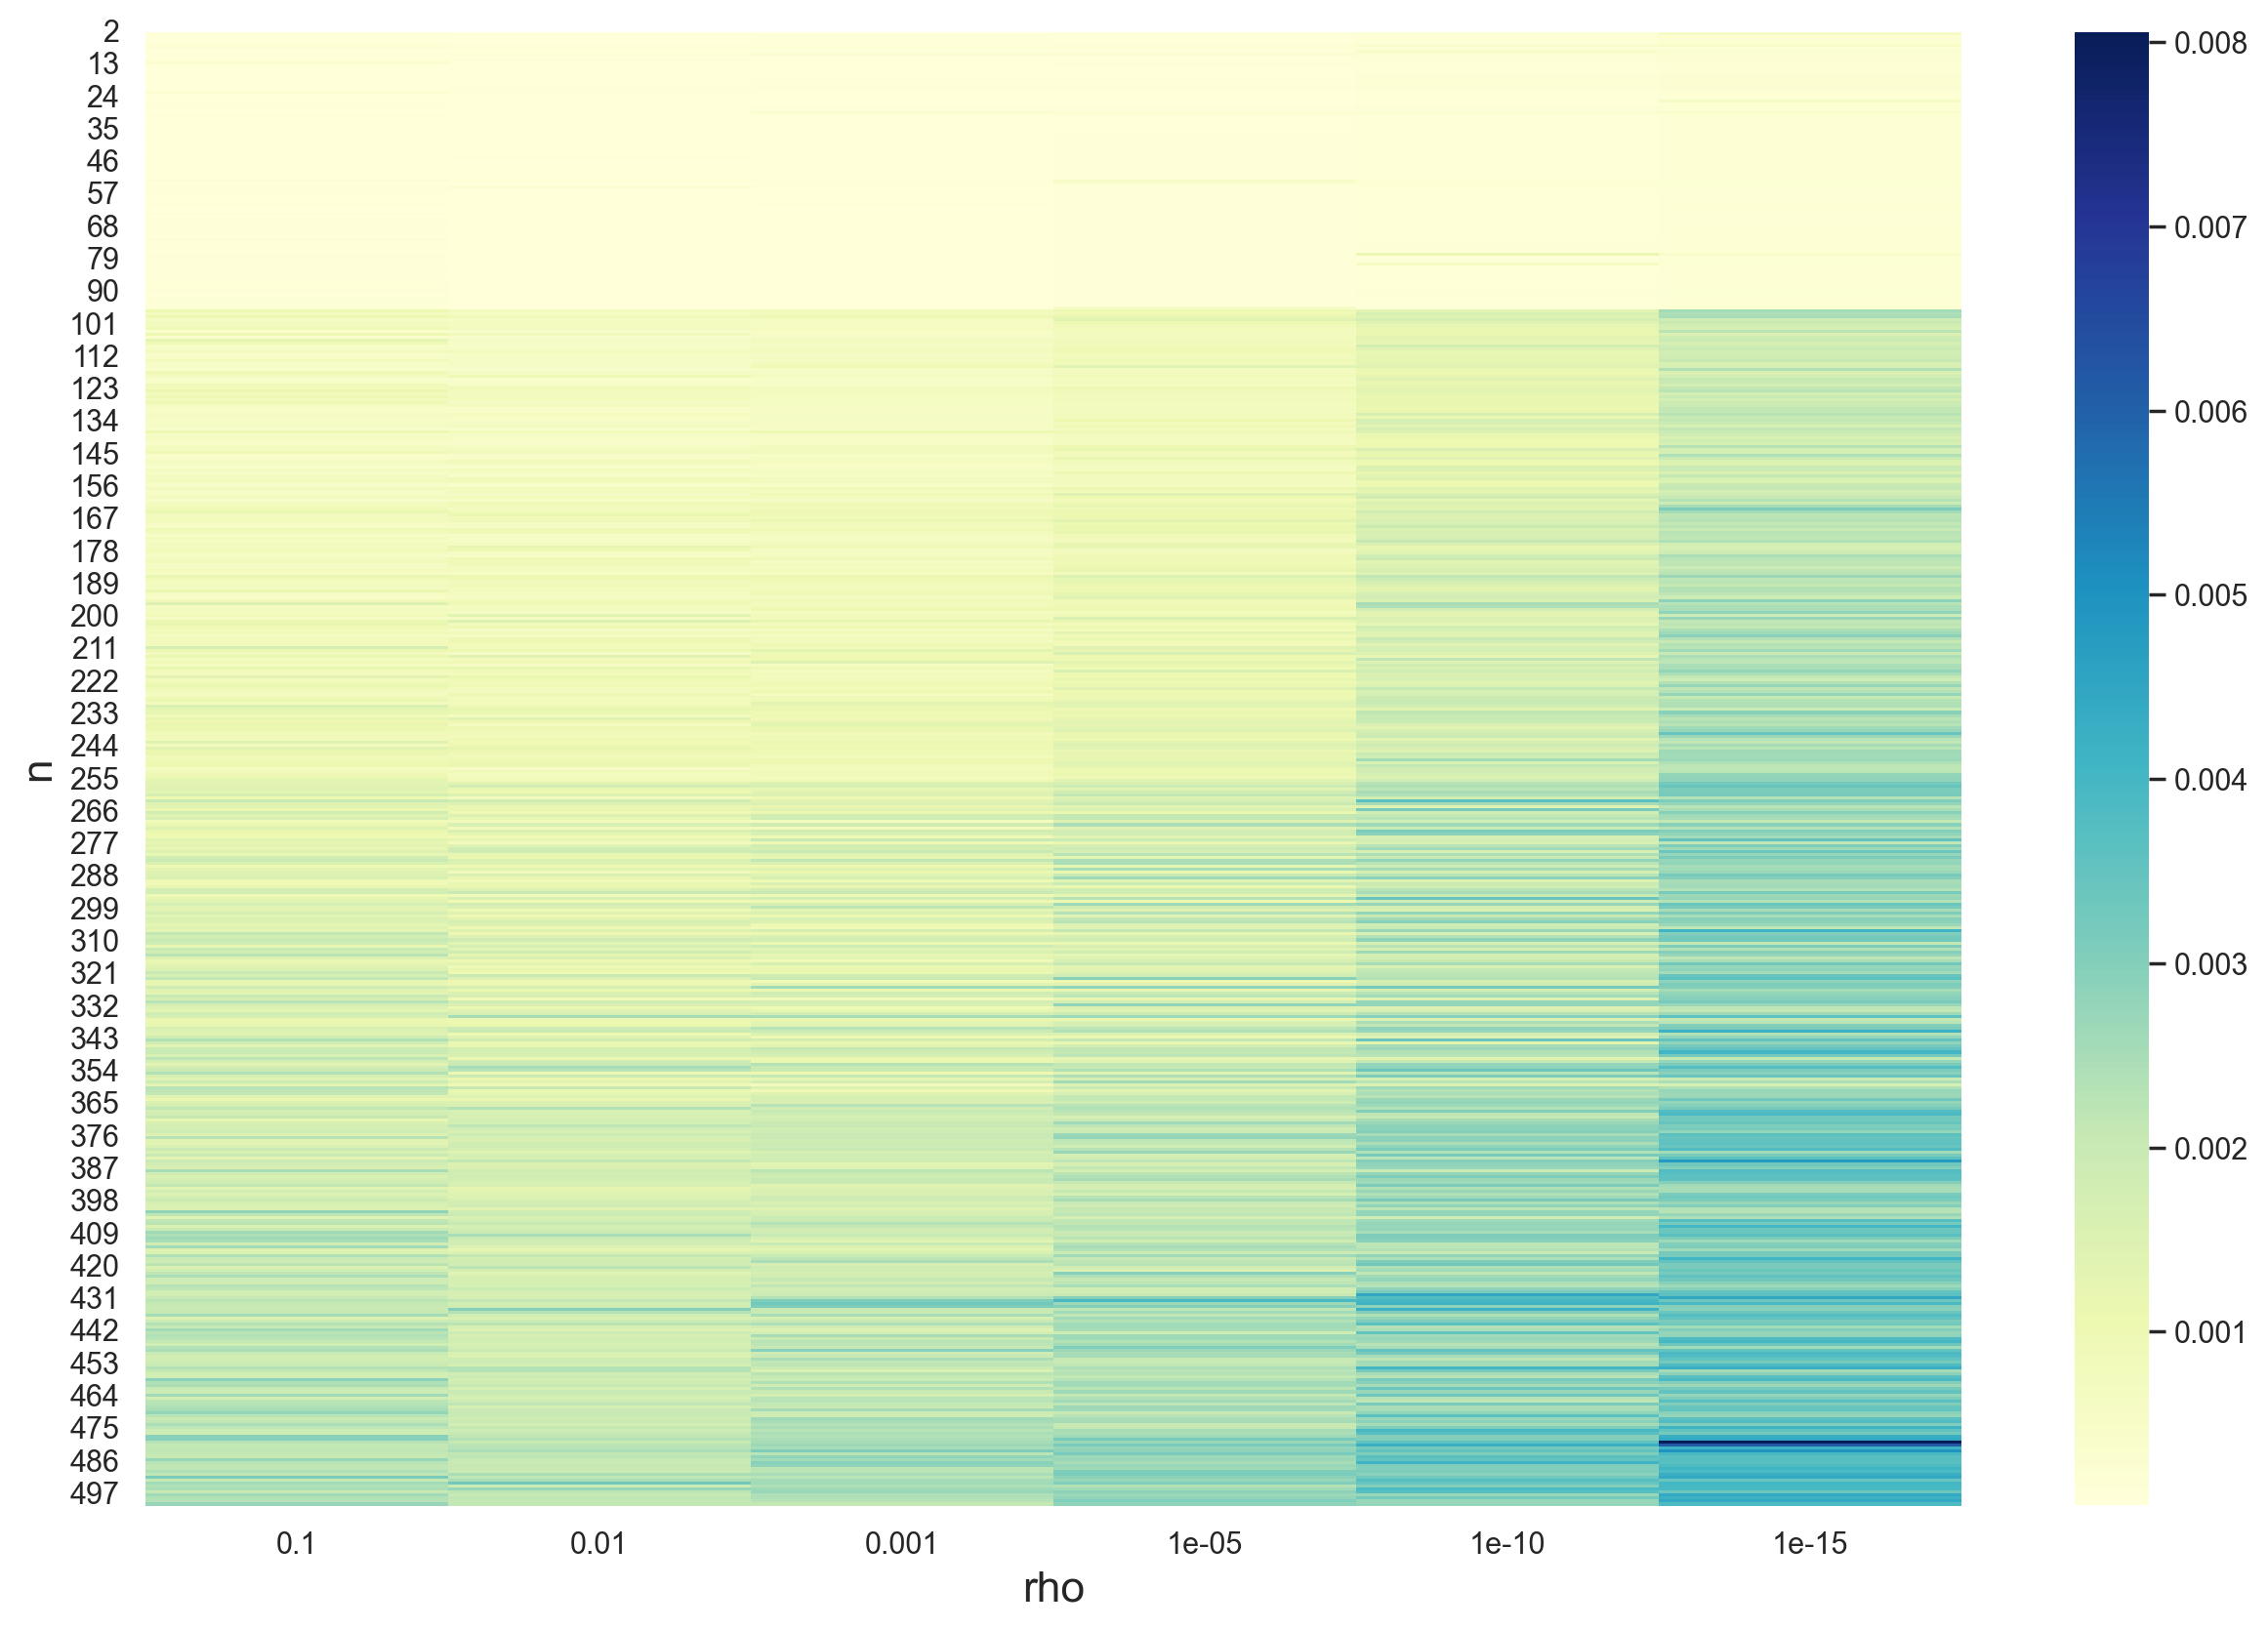

In [36]:
show_heatmap(df_times1, xlabel='rho', ylabel='n', annot=False)

###### Wykres czasów w skali logarytmicznej

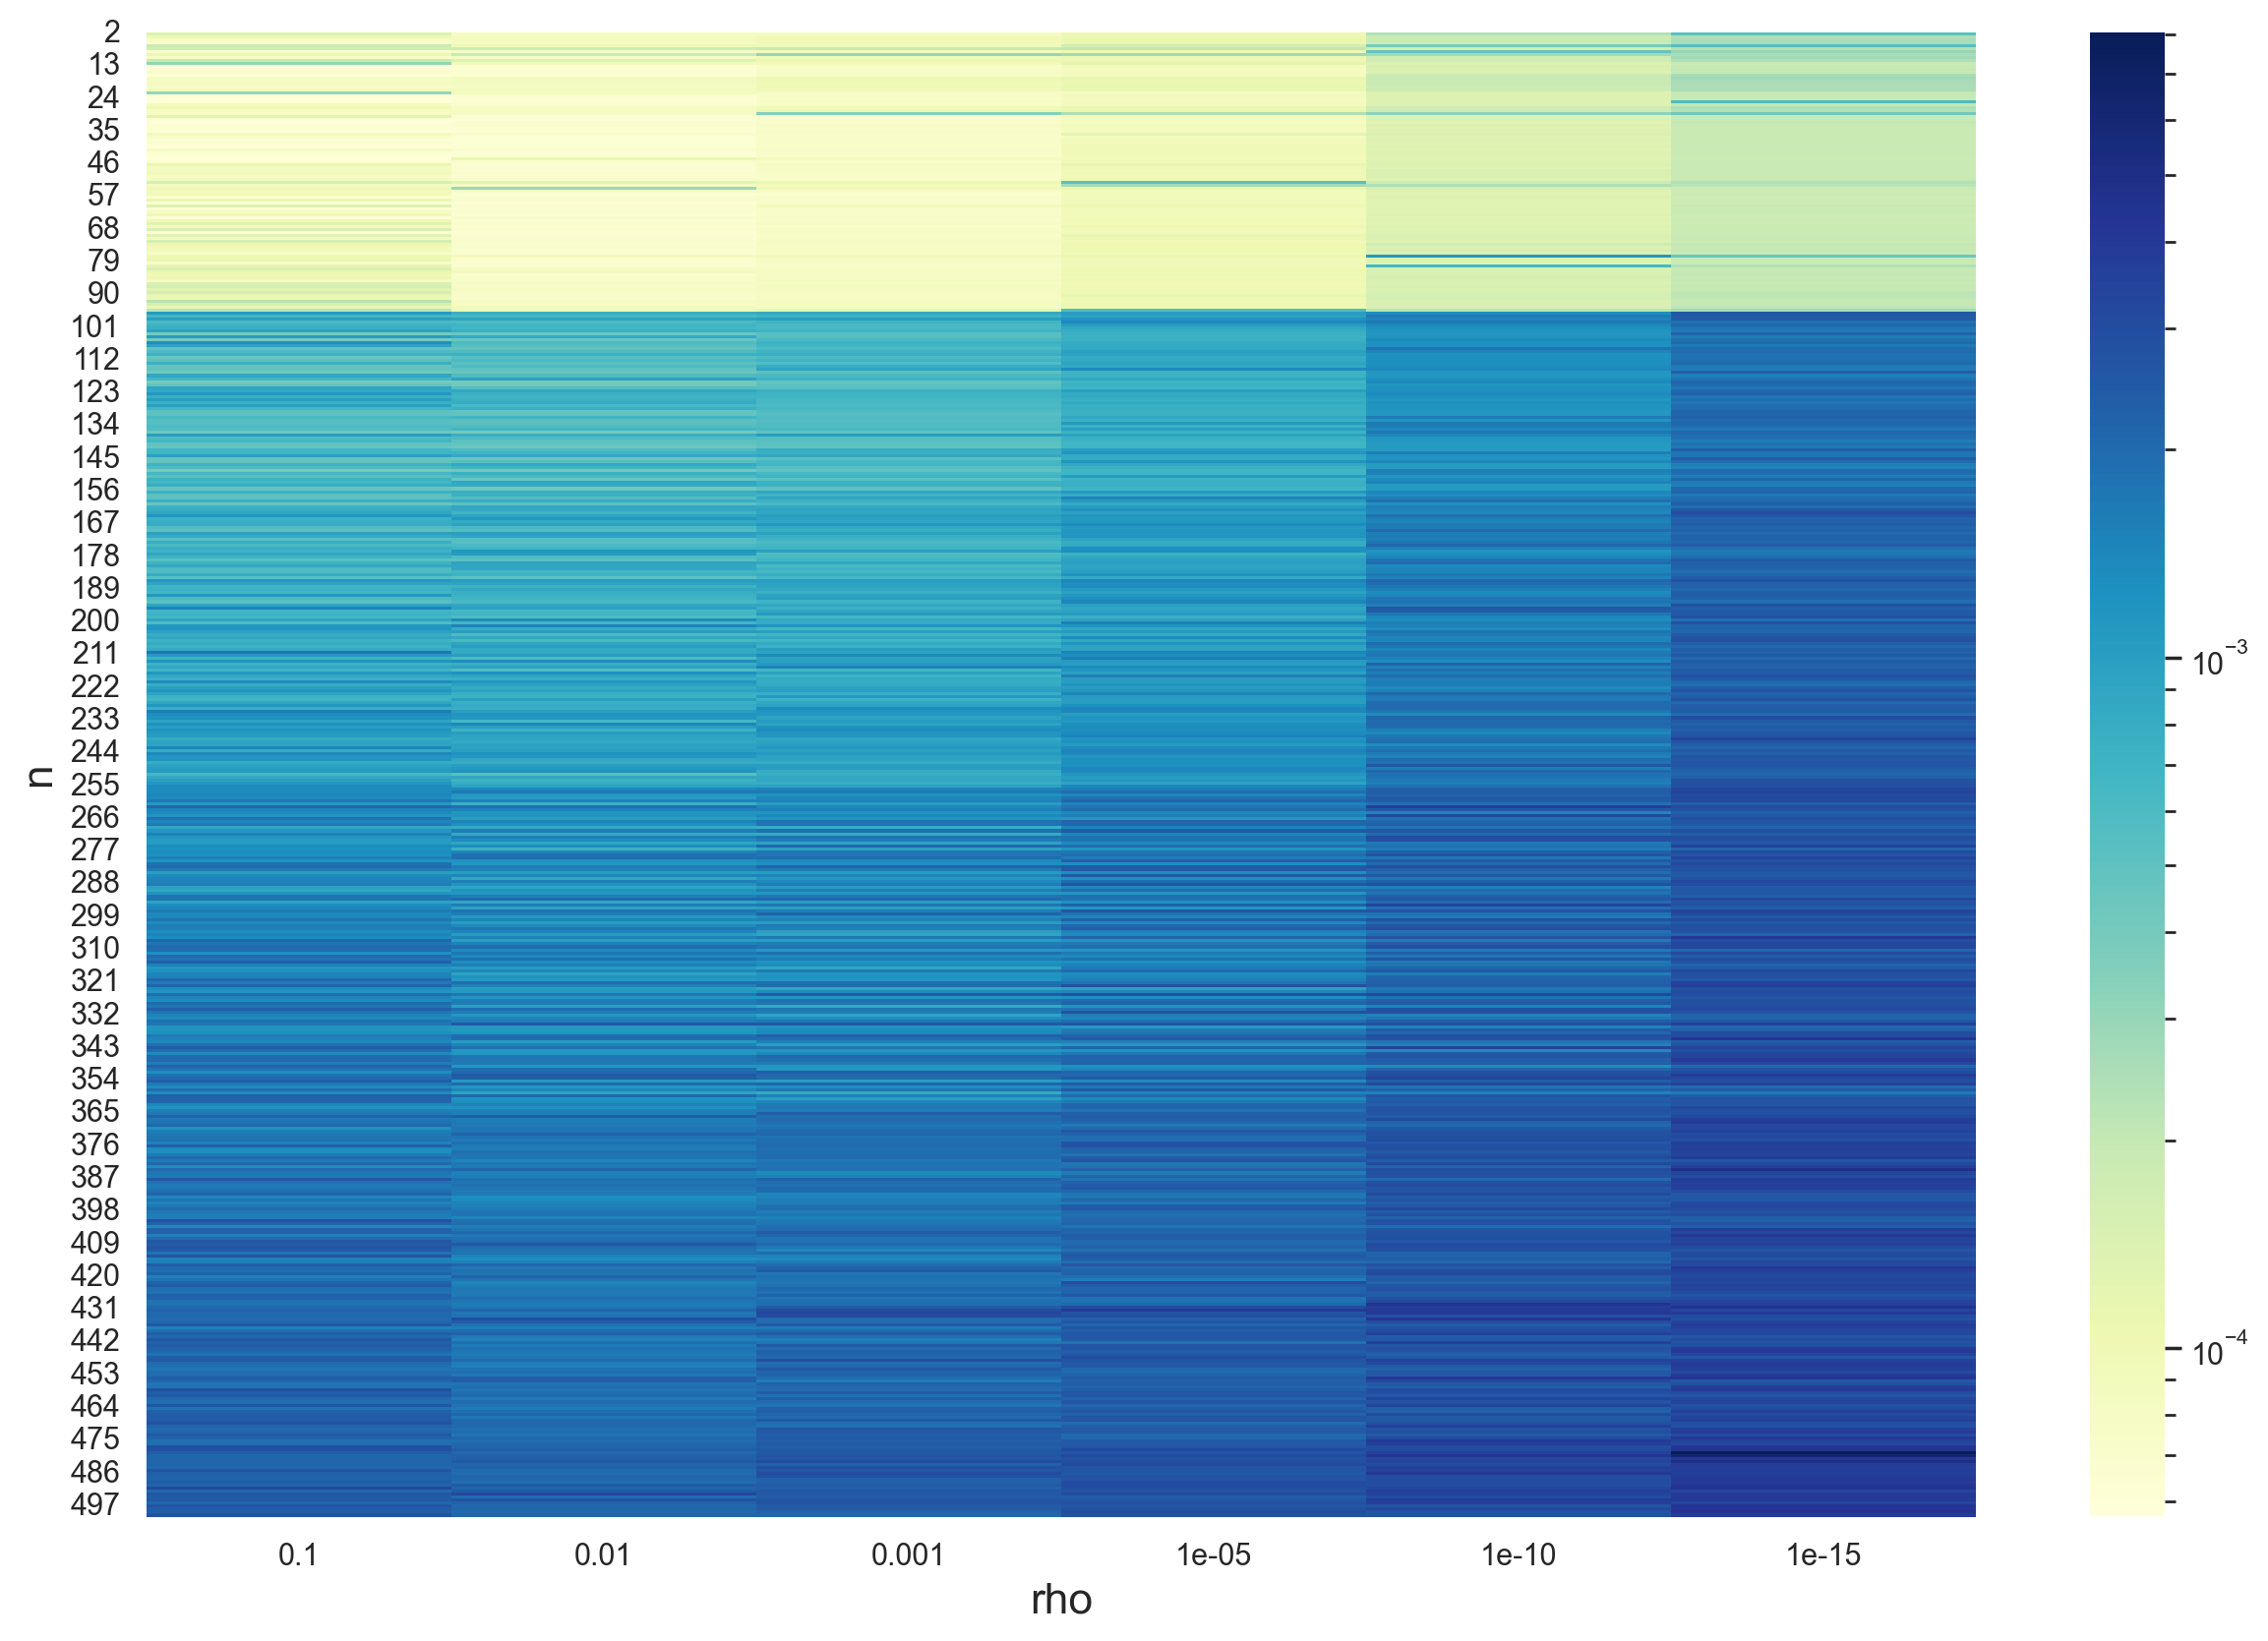

In [37]:
show_heatmap(df_times1, xlabel='rho', ylabel='n', annot=False, norm=LogNorm())

##### Błędy obliczeń

Jak możemy zauważyć, zmniejszanie wartości $\rho$ powoduje znaczny wzrost dokładności obliczeń. Możemy również zaobserwować, że zwiększanie wartości $n$ nie powoduje jednoznacznie pogorszenia dokładności obliczeń. Wyjaśnienie tego zjawiska jest proste, a dzieje się tak, dlatego, że wykonujemy różną liczbę iteracji (tyle, ile potrzeba, aby spełnione zostało kryterium stopu). Może się więc zdarzyć, że wartość, dla której uzyskujemy bardzo duży błąd (w porównaniu do pozostałych wartości) zostanie uznana za wystarczająco dokładną, ponieważ spełnione będzie kryterium stopu. Wówczas, dalsze zwiększanie wartości $n$ powoduje, że błąd obliczeń jest większy (przy ustalonej liczbie iteracji), więc może się okazać, że tym razem, dla tej samej liczby iteracji, co poprzednio, wynik nie jest wystarczająco dokładny, więc konieczne jest wykonanie jeszcze jednej iteracji. Wykonanie dodatkowej iteracji powoduje, że otrzymujemy znacznie wyższą dokładność wyniku niż wcześniej, a więc na poniższym wykresie, obserwujemy gwałtowną zmianę barwy podczas zwiększania wartości $n$.

In [38]:
df_errors1 = results1['errors']
df_errors1

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.001063,0.000097,0.000097,7.982867e-07,4.956625e-12,0.000000e+00
3,0.001288,0.000102,0.000009,8.907753e-07,5.409114e-12,0.000000e+00
4,0.001437,0.000108,0.000010,9.255833e-07,5.702960e-12,0.000000e+00
5,0.001517,0.000110,0.000010,9.926783e-07,5.805440e-12,0.000000e+00
6,0.001545,0.000111,0.000010,9.992201e-07,5.803612e-12,3.330669e-16
...,...,...,...,...,...,...
496,0.000351,0.000351,0.000016,8.954752e-08,6.461528e-12,7.849677e-15
497,0.000351,0.000351,0.000016,8.956096e-08,6.461783e-12,8.409161e-15
498,0.000351,0.000351,0.000016,8.957430e-08,6.462211e-12,8.484312e-15
499,0.000351,0.000351,0.000016,8.958770e-08,6.462691e-12,7.581287e-15


In [39]:
min_n = 2
interval = 20
df_errors1_part = df_errors1.iloc[ns]
df_errors1_part.to_excel('zad1-errors1-part.xlsx')
df_errors1_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.001063,0.000097,0.000097,7.982867e-07,4.956625e-12,0.000000e+00
15,0.001607,0.000131,0.000010,1.146522e-06,5.920699e-12,3.330669e-16
30,0.001689,0.000160,0.000010,1.271480e-06,6.013302e-12,5.978734e-16
45,0.001823,0.000182,0.000011,7.895538e-08,6.071603e-12,6.473657e-16
60,0.001962,0.000200,0.000011,7.958686e-08,6.114352e-12,1.174950e-15
75,0.002094,0.000214,0.000012,8.020834e-08,6.148420e-12,1.430422e-15
90,0.002217,0.000226,0.000012,8.079694e-08,6.176780e-12,1.612692e-15
105,0.002330,0.000236,0.000012,8.135214e-08,6.200934e-12,1.870981e-15
120,0.002435,0.000246,0.000013,8.187300e-08,6.222034e-12,2.519497e-15
135,0.002532,0.000254,0.000013,8.236410e-08,6.241207e-12,2.373386e-15


###### Wykres błędów obliczeń w skali liniowej

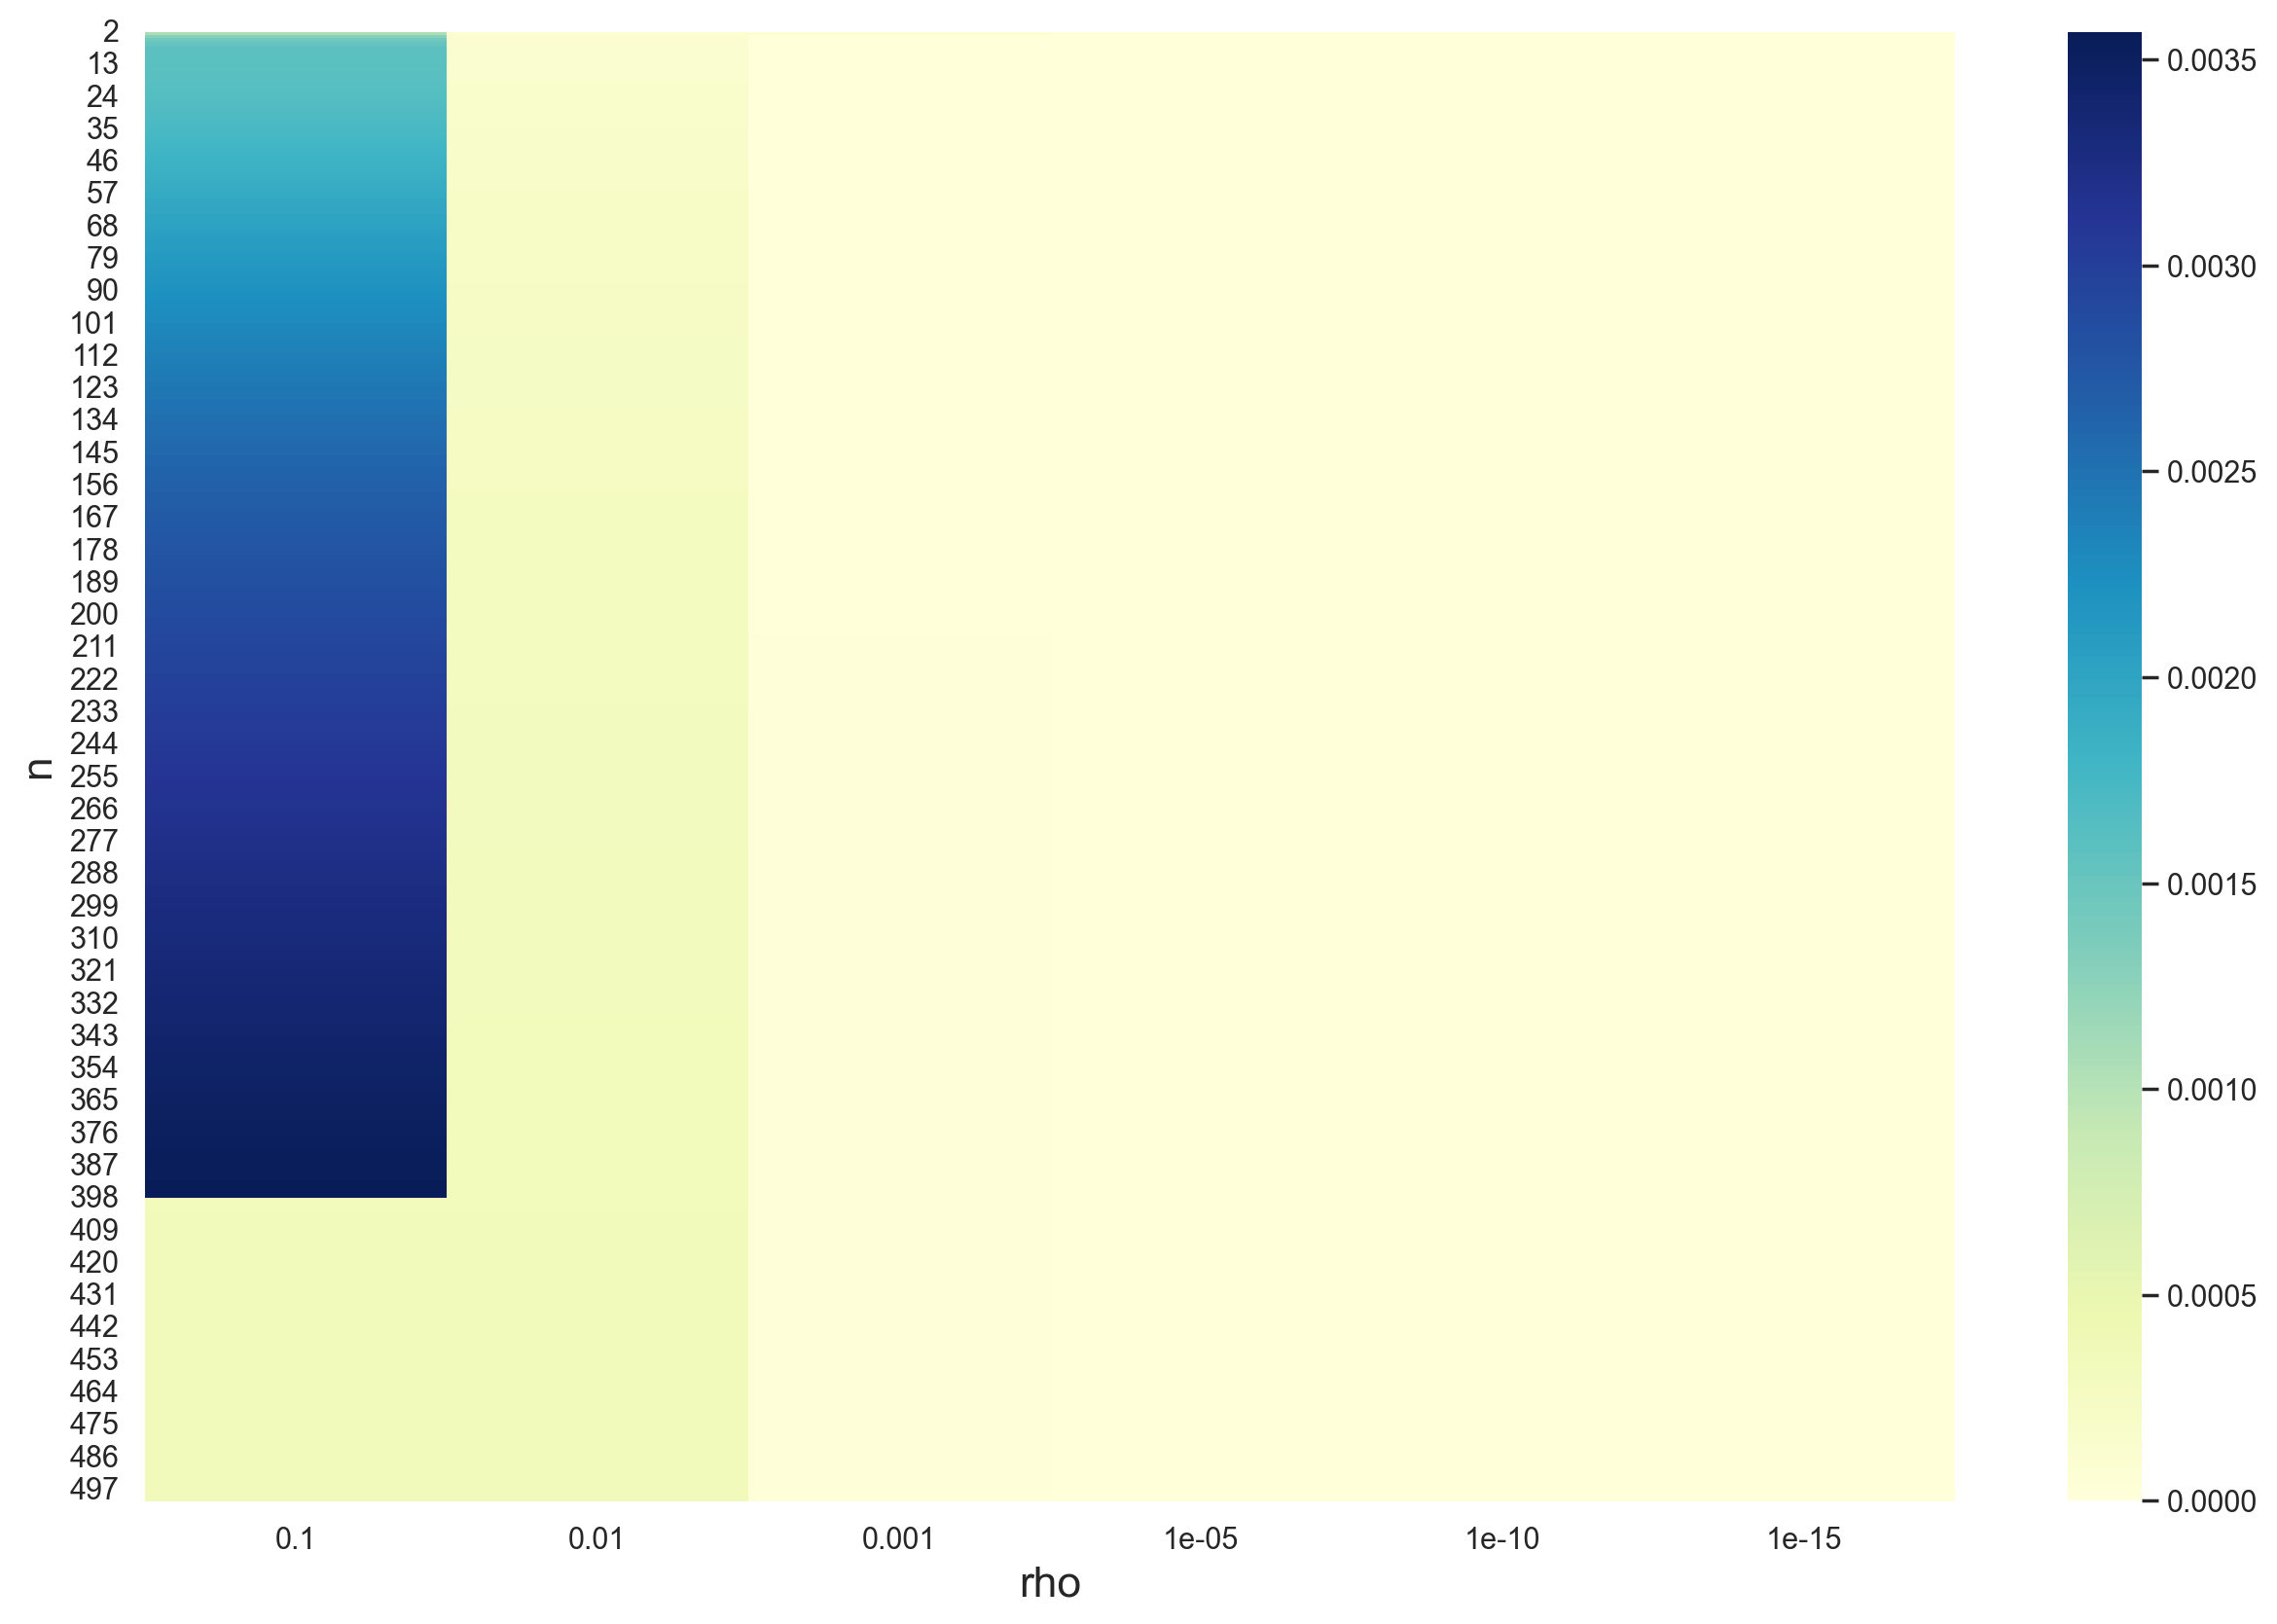

In [40]:
show_heatmap(df_errors1, xlabel='rho', ylabel='n', annot=False)

###### Wykres błędów obliczeń w skali logarytmicznej

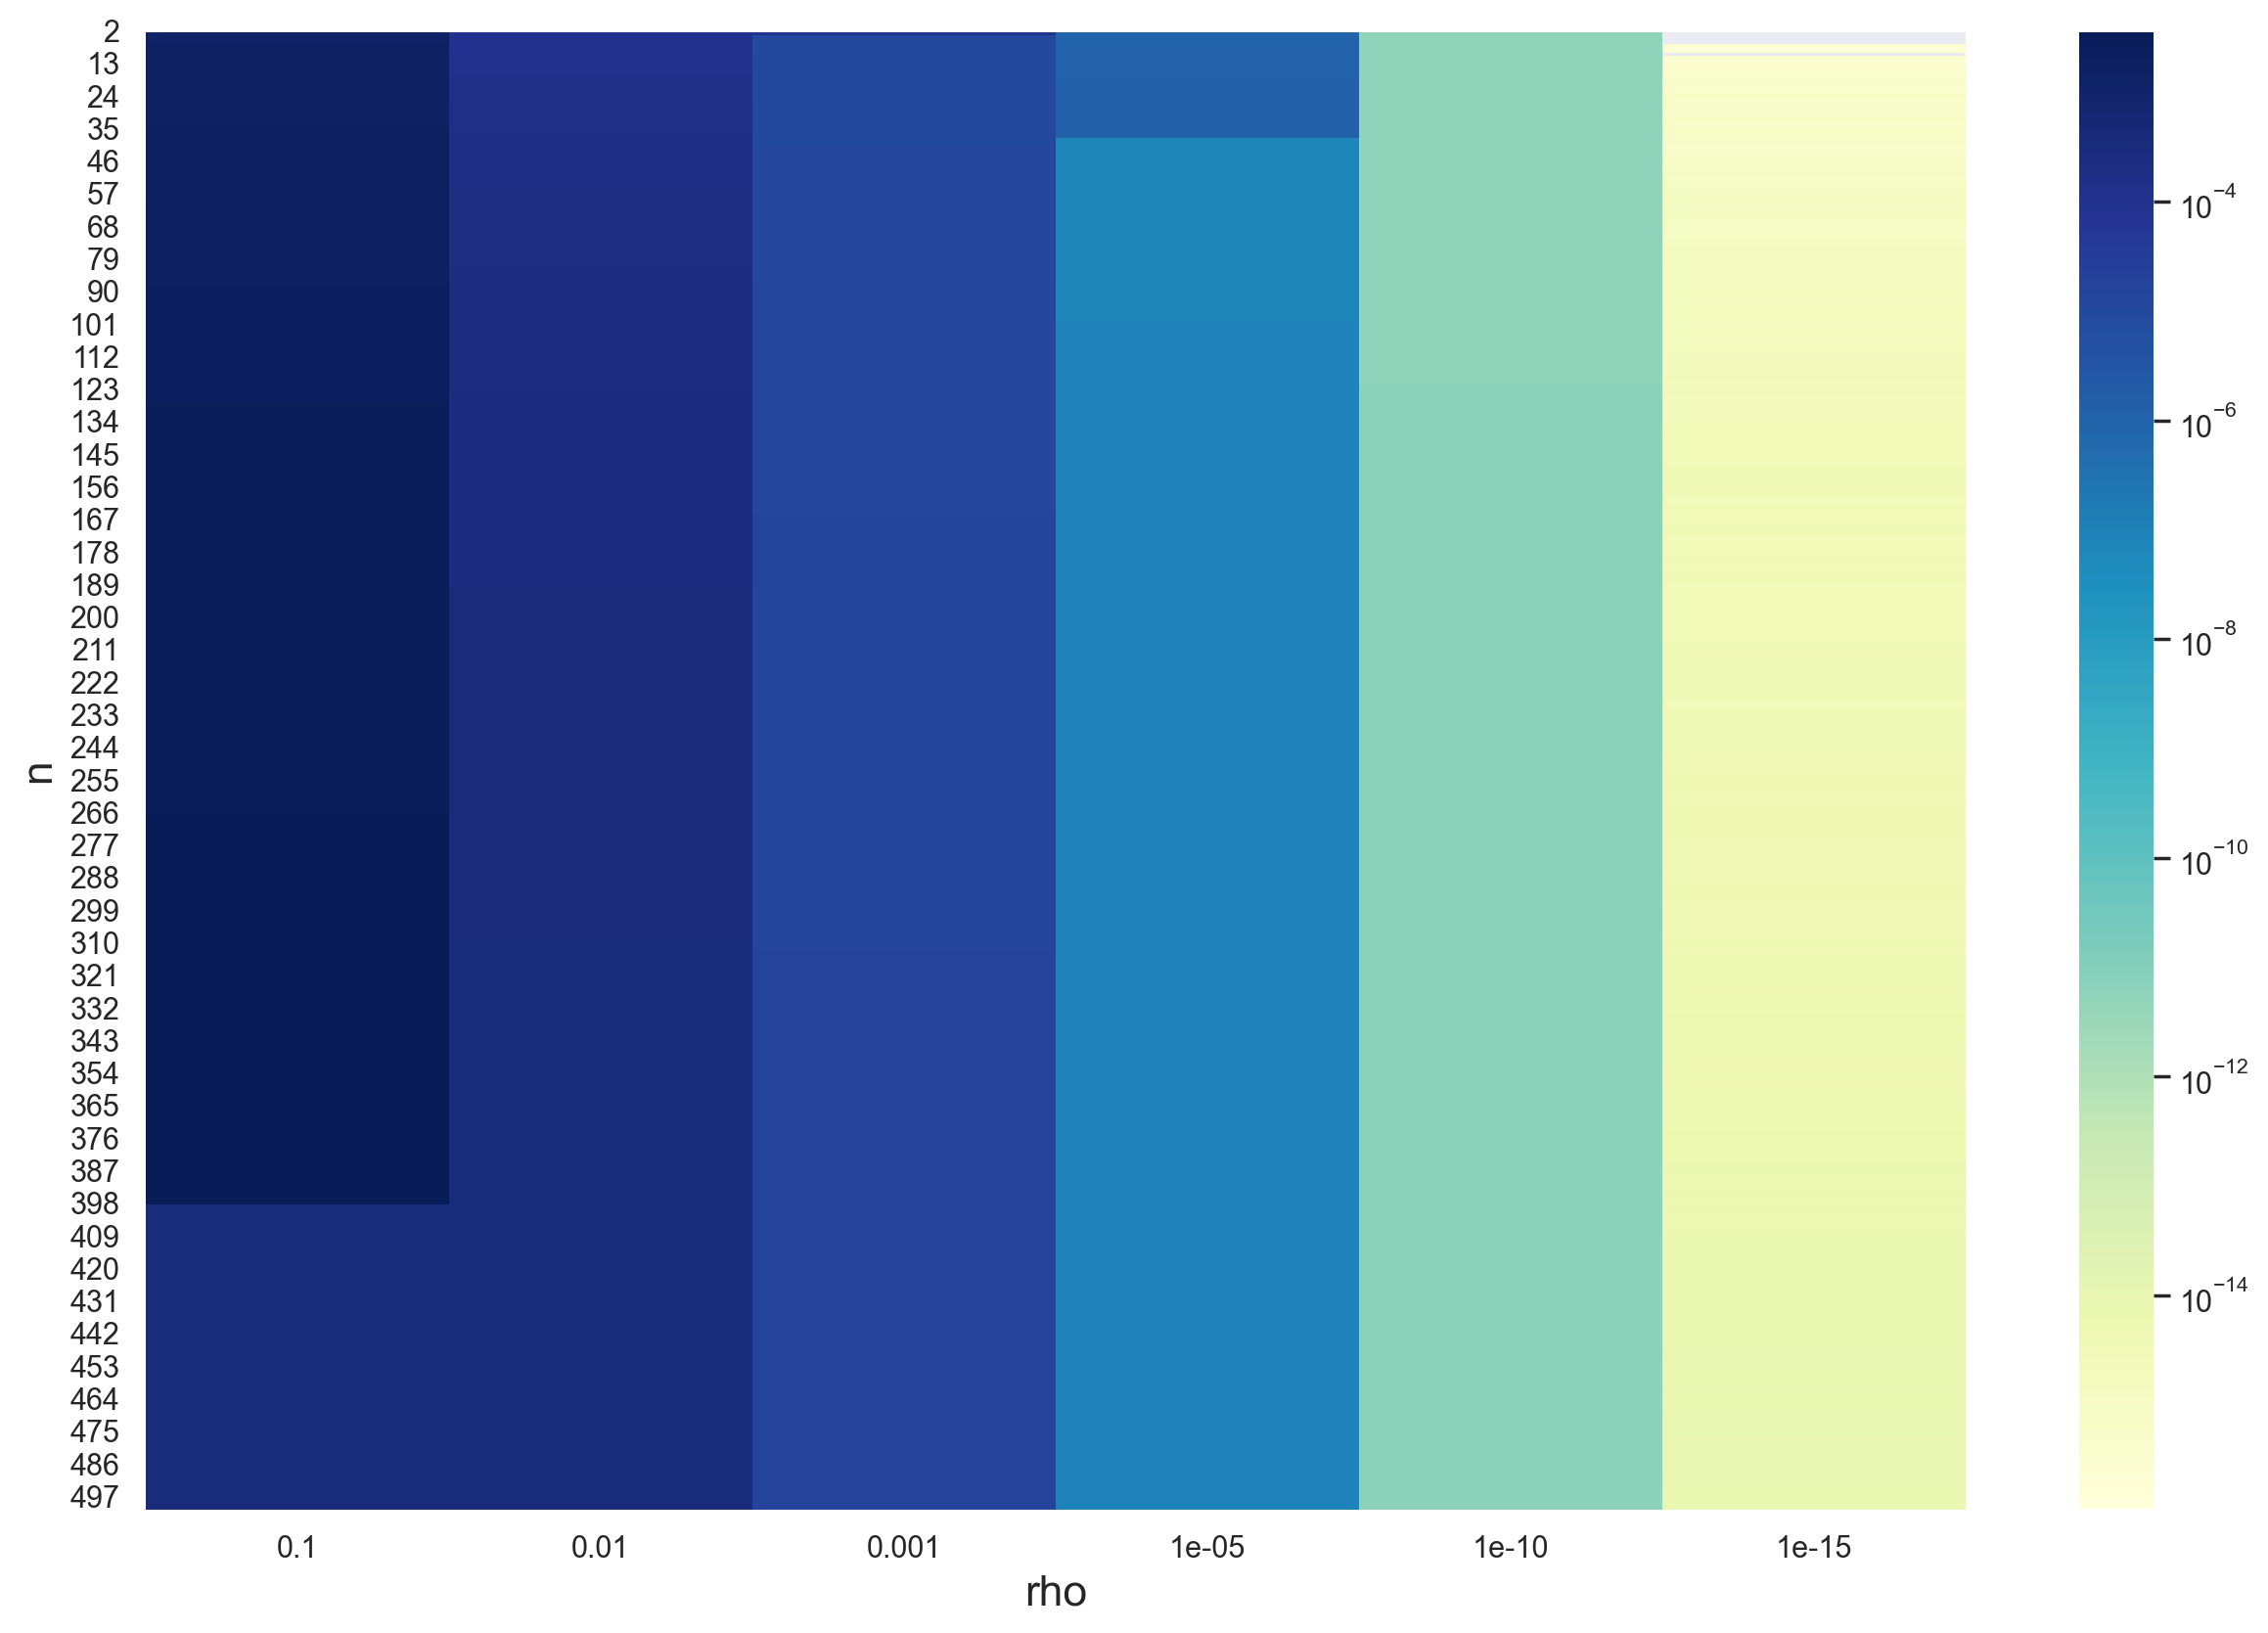

In [41]:
show_heatmap(df_errors1, xlabel='rho', ylabel='n', annot=False, norm=LogNorm())

###### Wpływ liczby iteracji na błąd obliczeń

Zamieszczone niżej fragmenty tabel przedtawiają liczbę iteracji oraz błędy dla $\rho=0.1$ w zależności od wartości $n$. Tak jak pisałem wcześniej, dokładnie widać, że w momencie, w którym liczba iteracji zwiększyła się z $3$ do $4$, dokładność obliczeń uległa natychmiastowej poprawie.

In [42]:
df_iters1.iloc[390:400, 0]

392    3
393    3
394    3
395    3
396    3
397    3
398    4
399    4
400    4
401    4
Name: 0.1, dtype: int32

In [43]:
df_errors1.iloc[390:400, 0]

392    0.003555
393    0.003557
394    0.003560
395    0.003563
396    0.003565
397    0.003568
398    0.000334
399    0.000334
400    0.000334
401    0.000334
Name: 0.1, dtype: float64

#### Dla 2. kryterium stopu

In [44]:
n_list = list(range(2, 501))
start_vector_fn = lambda _: 0
𝜌_list = [
    1e-1,
    1e-2,
    1e-3,
    1e-5,
    1e-10,
    1e-15
]
stop_criterion = solution_difference

results2 = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 100 wartości n
Obliczono układy równań dla 125 wartości n
Obliczono układy równań dla 150 wartości n
Obliczono układy równań dla 175 wartości n
Obliczono układy równań dla 200 wartości n
Obliczono układy równań dla 225 wartości n
Obliczono układy równań dla 250 wartości n
Obliczono układy równań dla 275 wartości n
Obliczono układy równań dla 300 wartości n
Obliczono układy równań dla 325 wartości n
Obliczono układy równań dla 350 wartości n
Obliczono układy równań dla 375 wartości n
Obliczono układy równań dla 400 wartości n
Obliczono układy równań dla 425 wartości n
Obliczono układy równań dla 450 wartości n
Obliczono układy równań dla 475 wartości n
Obliczono układy równań dla 499 wartości n
Łączny czas wykonania: 00:02:07.864


##### Liczby iteracji

Jak widzimy, nie da się wyznaczyć rozwiązań dla niektórych wartości $n$, gdy $\rho = 10^{-15}$. Dzieje się tak prawdopodobnie wskutek pojawienia się dużego błędu zaokręgleń, przez co kryterium stopu nigdy nie jest spełnione.

In [45]:
df_iters2 = results2['iters']
df_iters2

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,4,5,5,7,12,17
3,4,5,6,7,12,17
4,4,5,6,7,12,17
5,4,5,6,8,12,17
6,4,5,6,8,12,17
...,...,...,...,...,...,...
496,4,5,6,8,12,-1
497,4,5,6,8,12,-1
498,4,5,6,8,12,-1
499,4,5,6,8,12,-1


In [46]:
df_iters2_part = df_iters2.iloc[ns]
df_iters2_part.replace(-1, '-').to_excel('zad1-iters2-part.xlsx')
df_iters2_part.replace(-1, '-')

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,4,5,5,7,12,17
15,4,5,6,8,12,-
30,4,5,6,8,12,-
45,4,5,6,8,12,-
60,4,5,6,8,12,-
75,4,5,6,8,12,-
90,4,5,6,8,12,-
105,4,5,6,8,12,-
120,4,5,6,8,12,-
135,4,5,6,8,12,-


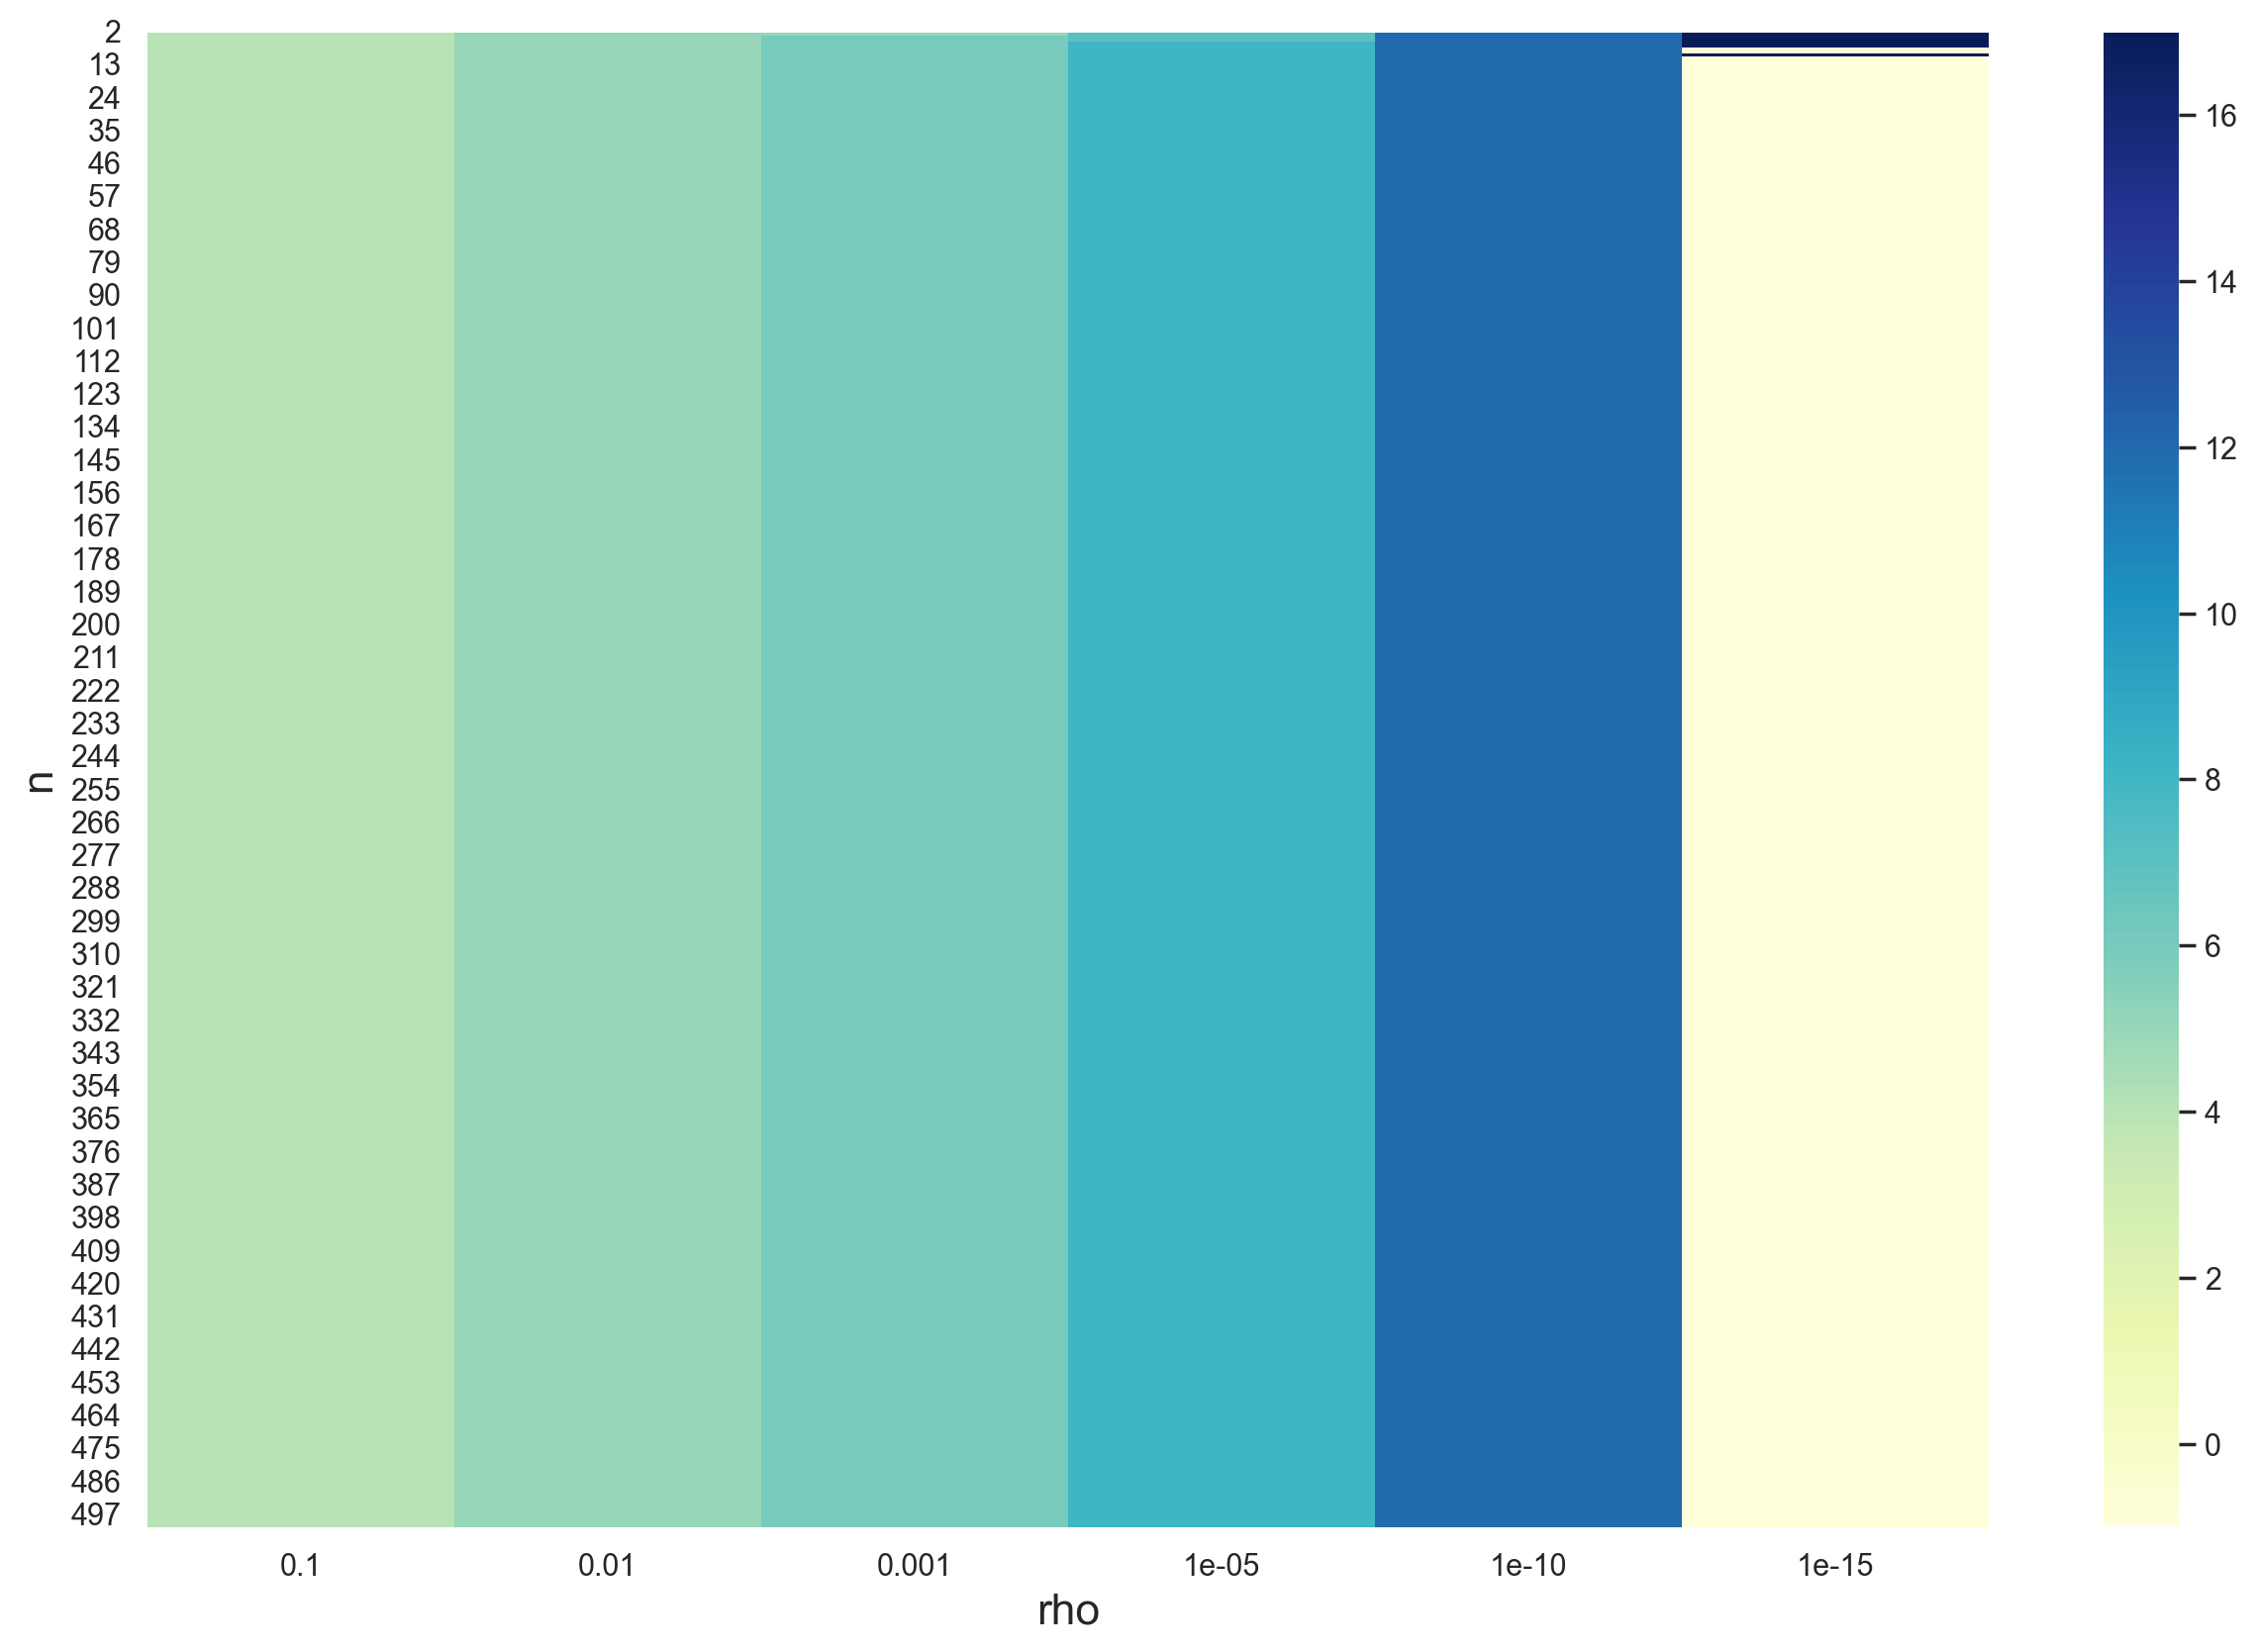

In [47]:
show_heatmap(df_iters2, xlabel='rho', ylabel='n', annot=False)

##### Czasy obliczeń

In [48]:
df_times2 = results2['times']
df_times2.replace(np.nan, '-')

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000162,0.000103,0.000095,0.000393,0.000196,0.000267
3,0.000195,0.000101,0.000530,0.000297,0.000217,0.000269
4,0.000430,0.000095,0.000090,0.000222,0.000178,0.000224
5,0.000073,0.000077,0.000090,0.000111,0.000168,0.000235
6,0.000074,0.000078,0.000090,0.000114,0.000171,0.000224
...,...,...,...,...,...,...
496,0.003195,0.002734,0.003058,0.004030,0.005196,-
497,0.003014,0.003400,0.003260,0.003545,0.004006,-
498,0.002994,0.002879,0.002899,0.003480,0.004866,-
499,0.002784,0.003394,0.003810,0.003669,0.006215,-


In [49]:
df_times2_part = df_times2.iloc[ns]
df_times2_part.replace(np.nan, '-').to_excel('zad1-times2-part.xlsx')
df_times2_part.replace(np.nan, '-')

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000162,0.000103,0.000095,0.000393,0.000196,0.000267
15,0.000099,0.000082,0.000111,0.000116,0.000163,-
30,0.000121,0.000078,0.000096,0.000108,0.000157,-
45,0.000131,0.000097,0.000099,0.000123,0.000172,-
60,0.000123,0.000081,0.000090,0.000113,0.000159,-
75,0.000161,0.000103,0.000110,0.000133,0.000207,-
90,0.000144,0.000108,0.000140,0.000161,0.000223,-
105,0.001367,0.001797,0.001319,0.001500,0.002125,-
120,0.001150,0.001425,0.001669,0.002036,0.003488,-
135,0.001429,0.001450,0.001877,0.002445,0.003020,-


###### Wykres czasów w skali liniowej

In [50]:
df_times2.max()

1.000000e-01    0.003679
1.000000e-02    0.004020
1.000000e-03    0.004164
1.000000e-05    0.004842
1.000000e-10    0.006807
1.000000e-15    0.000269
dtype: float64

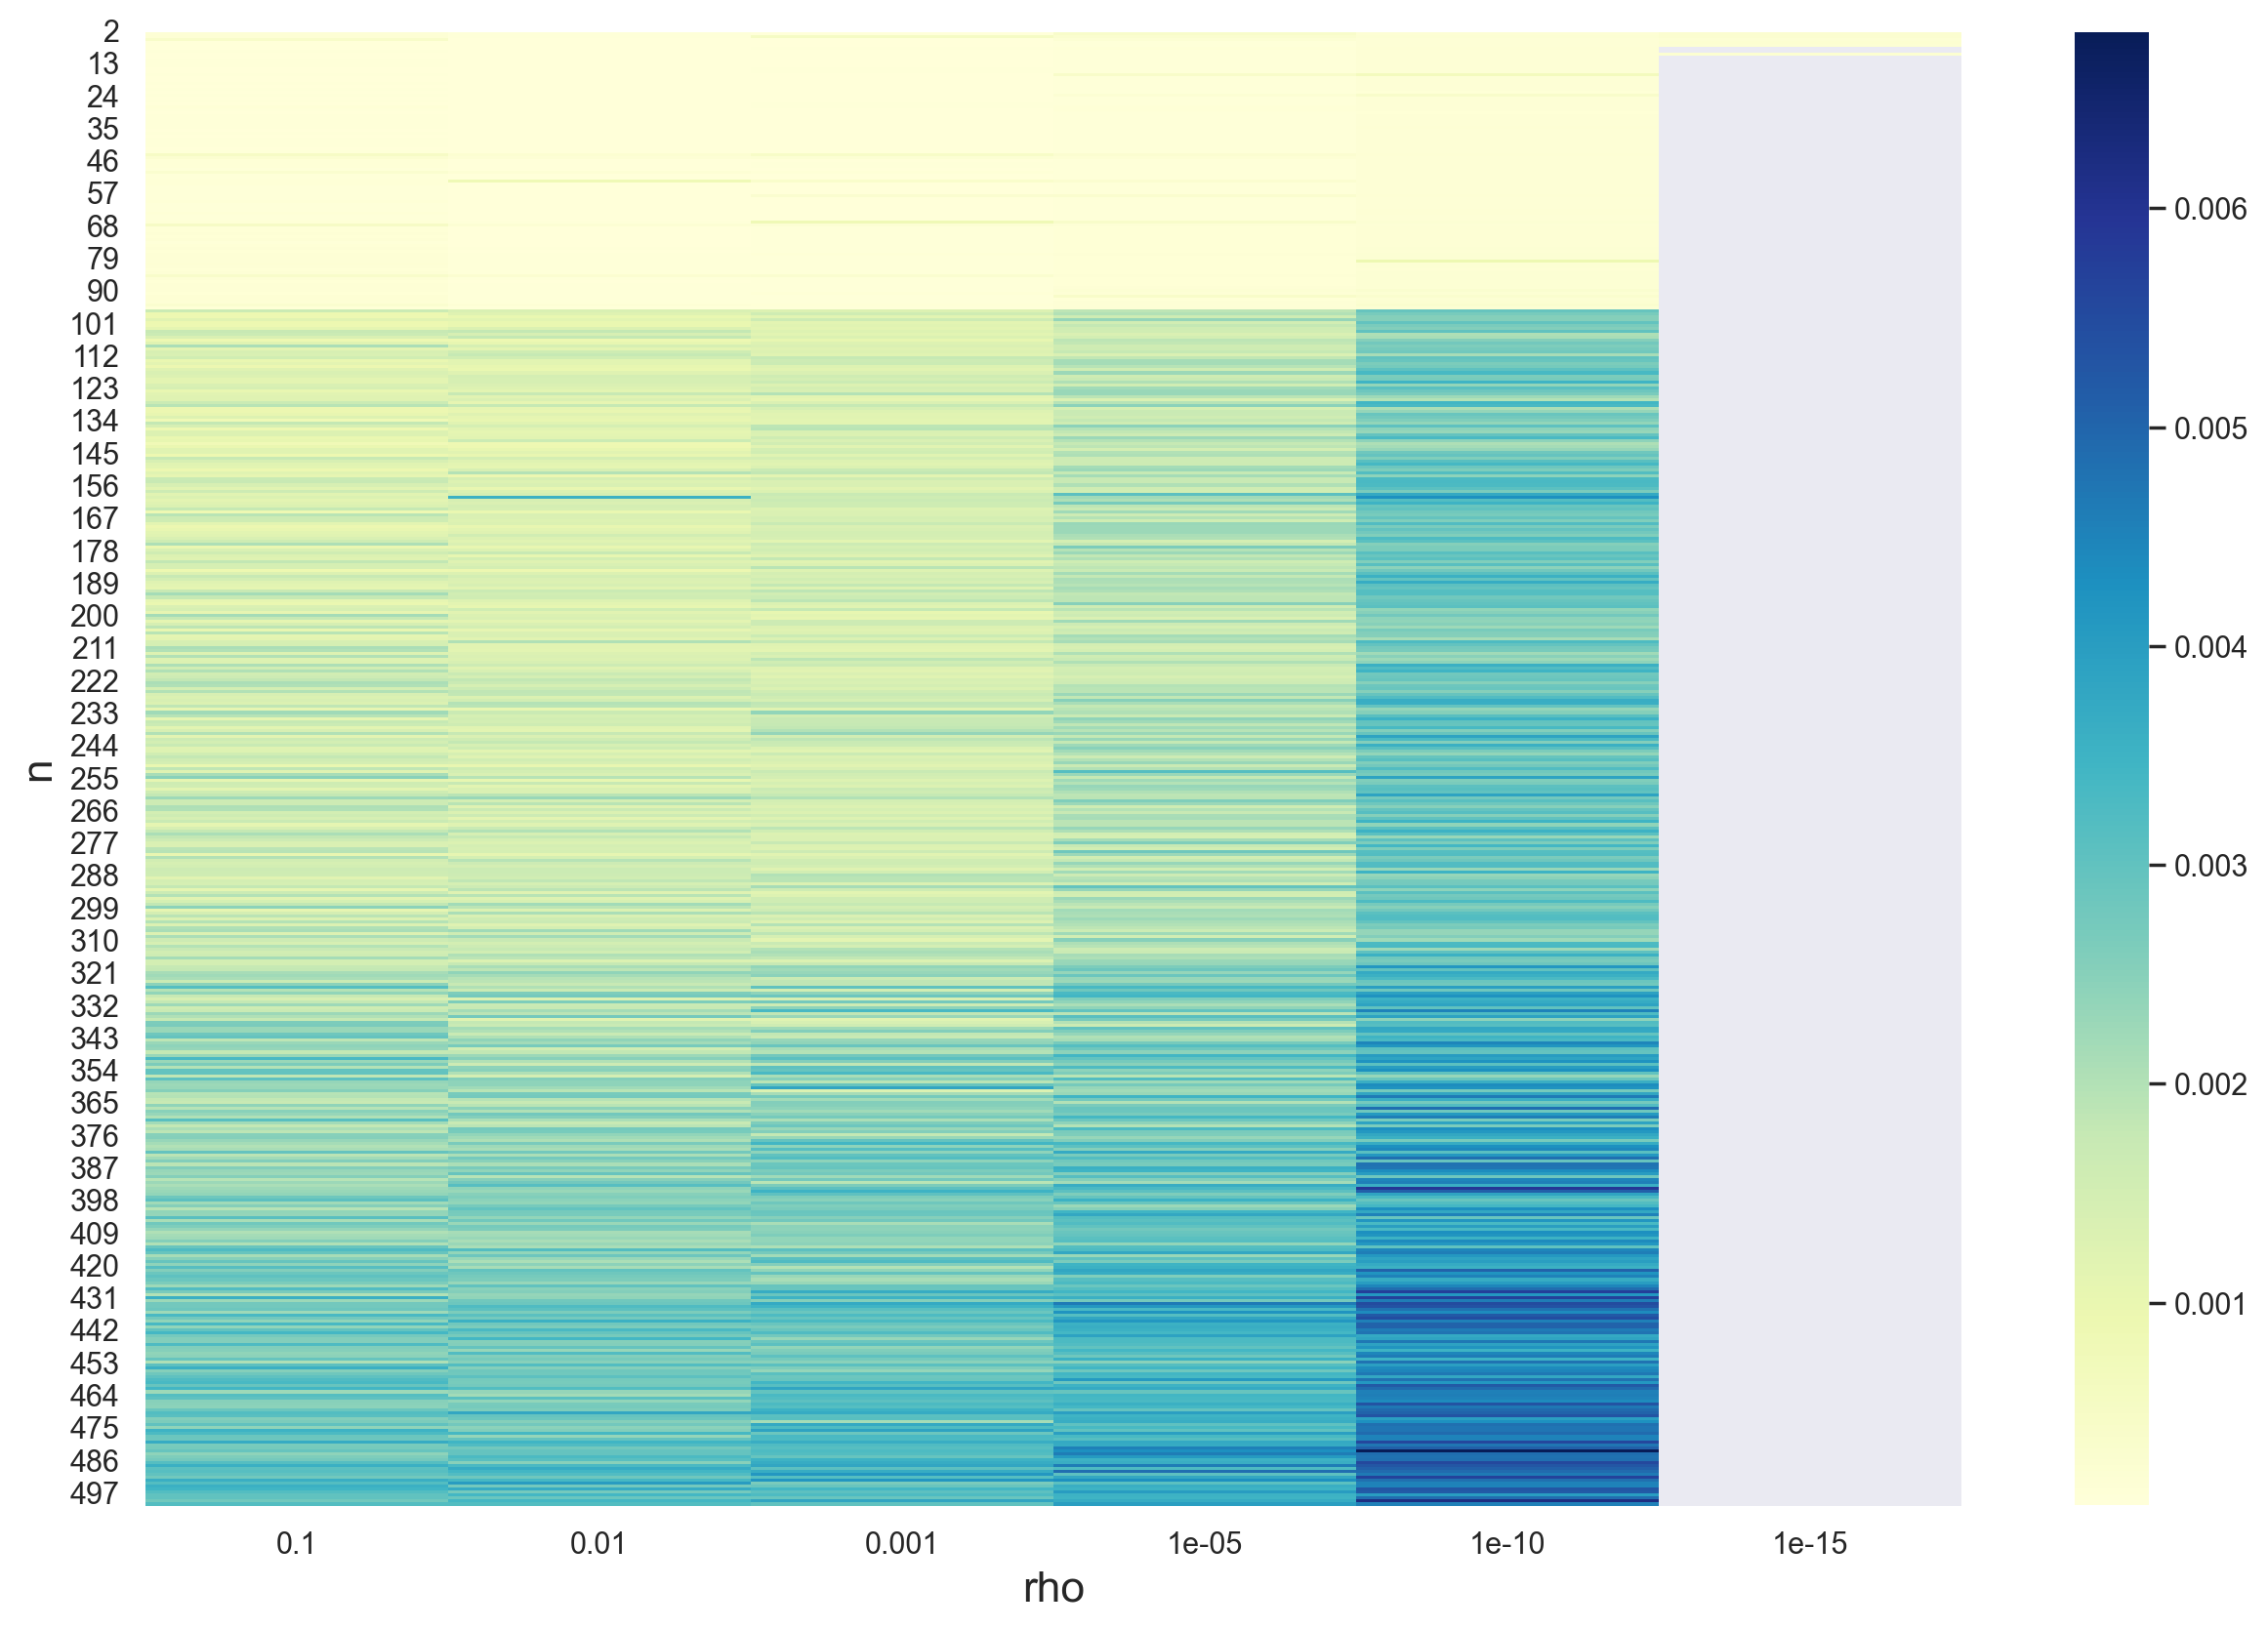

In [51]:
show_heatmap(df_times2, xlabel='rho', ylabel='n', annot=False)

###### Wykres czasów w skali logarytmicznej

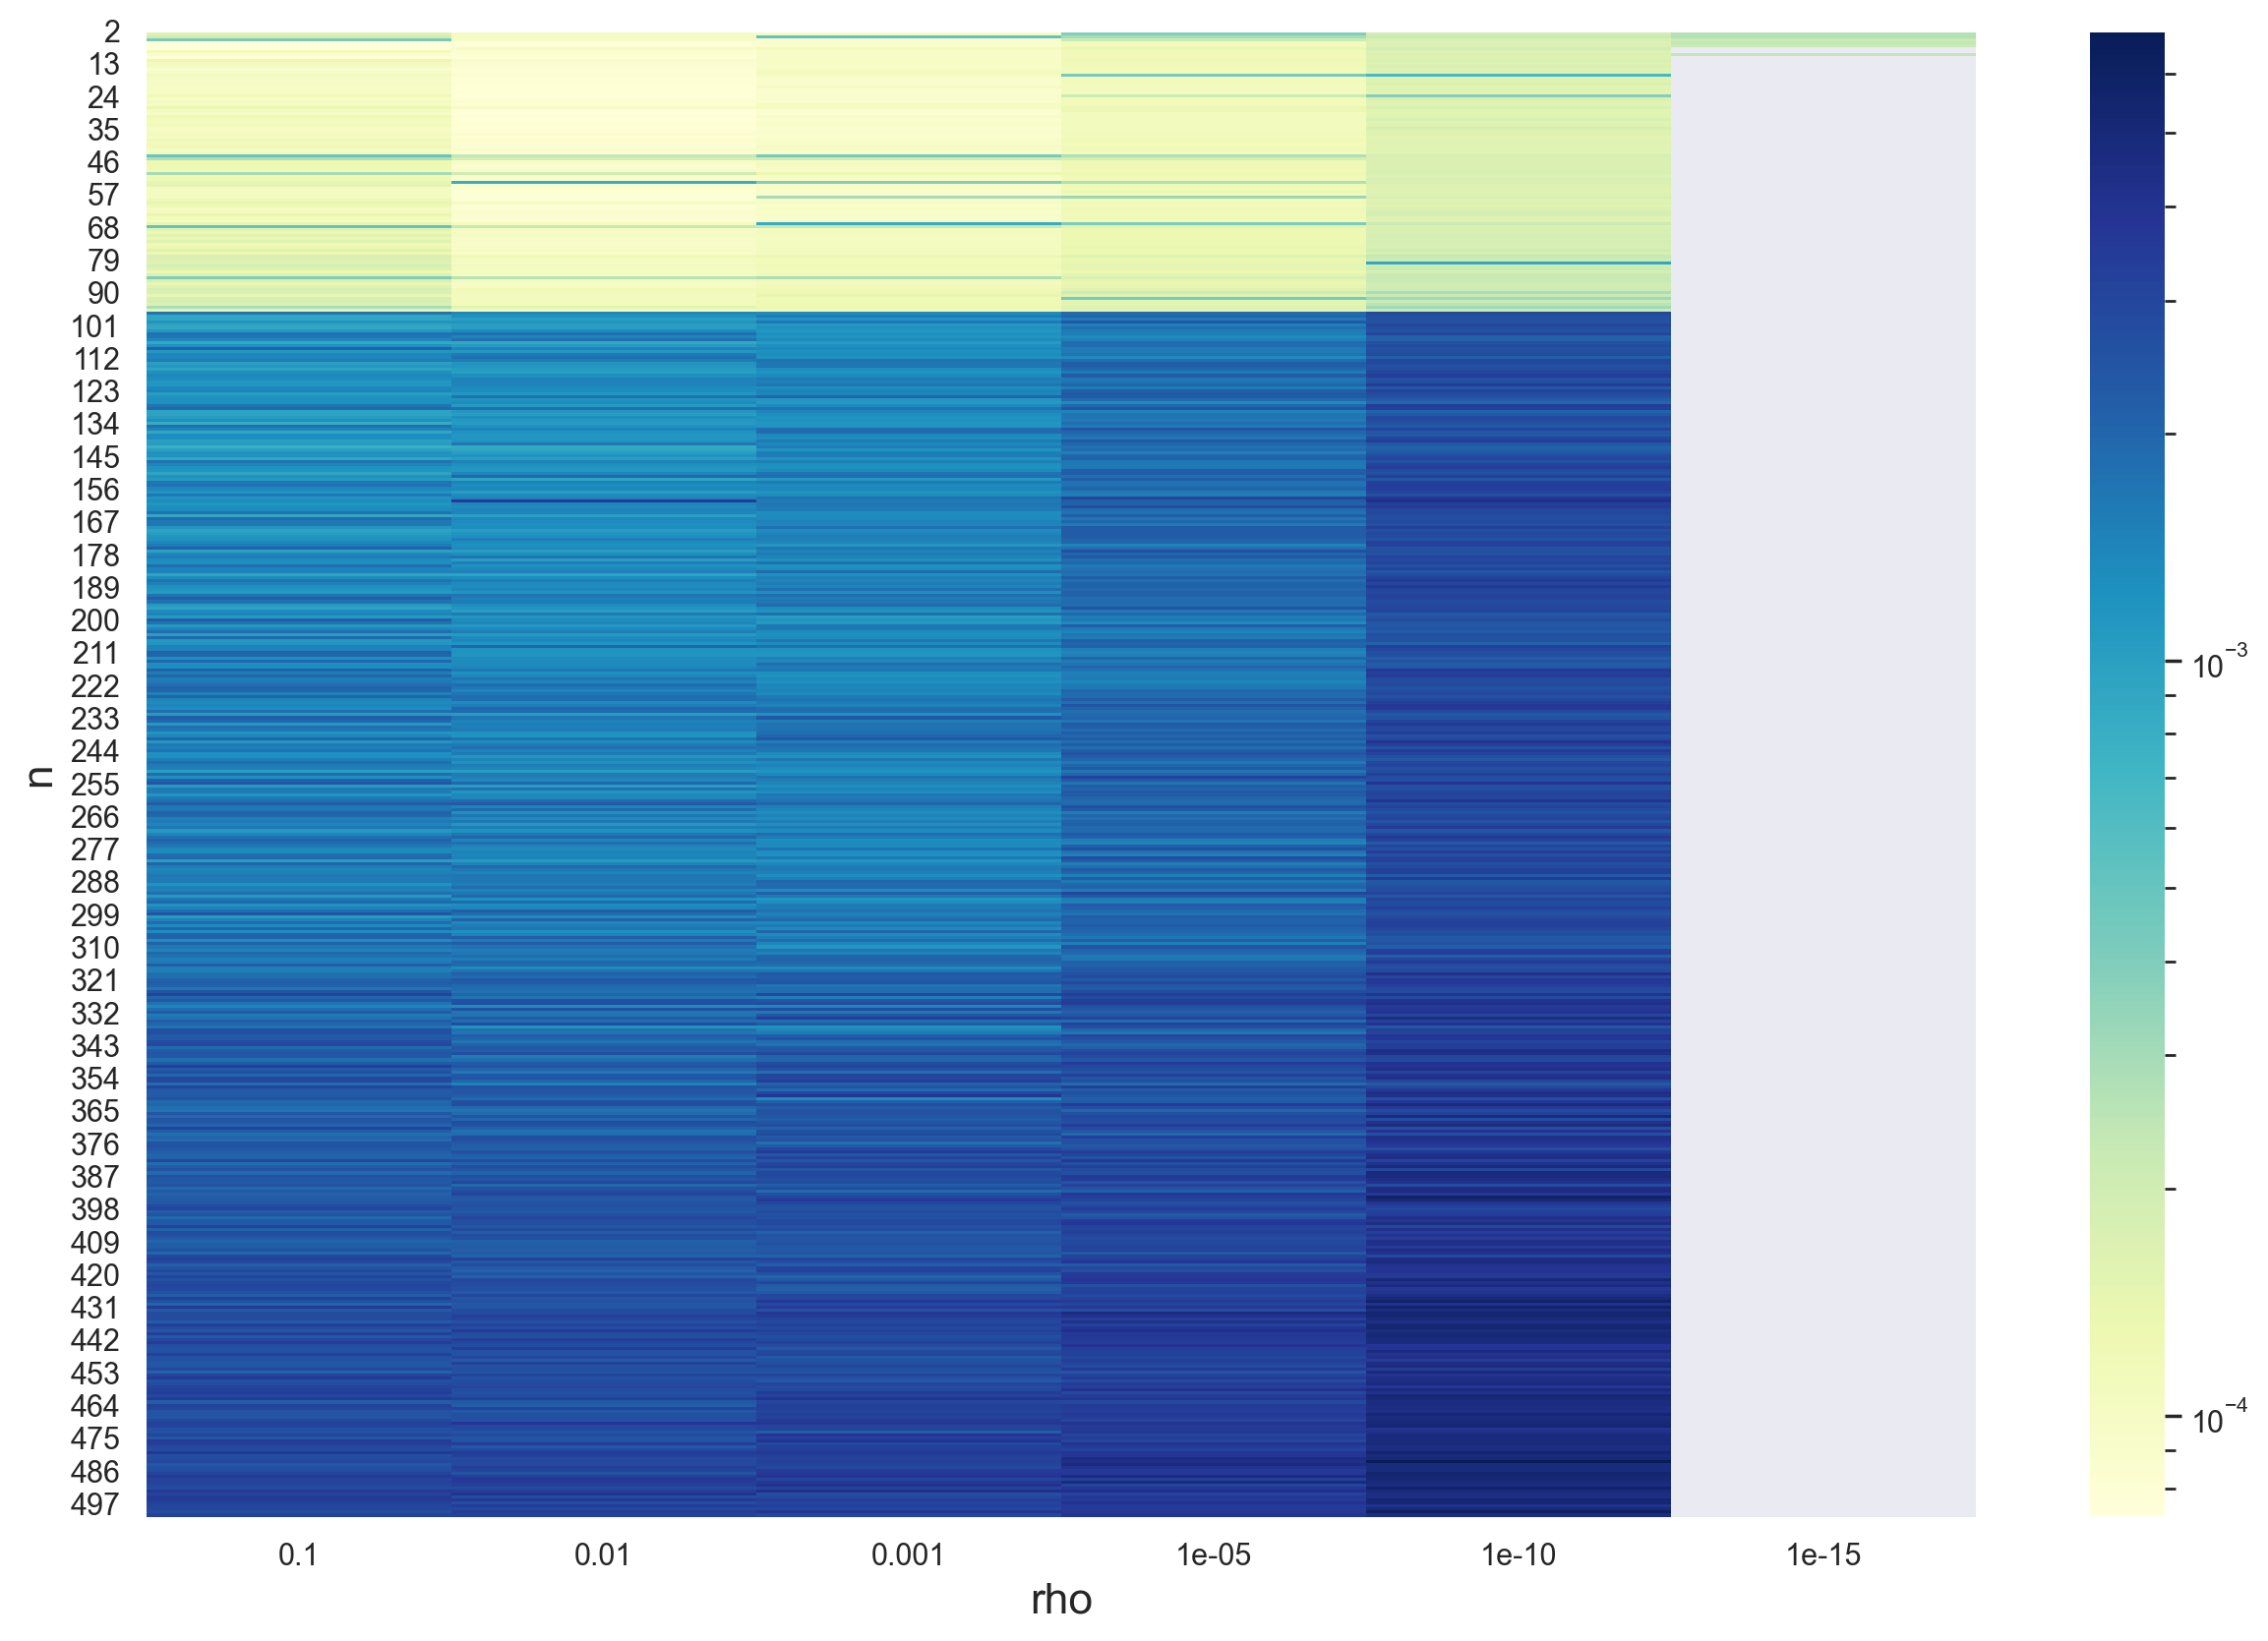

In [52]:
show_heatmap(df_times2, xlabel='rho', ylabel='n', annot=False, norm=LogNorm())

###### Błędy obliczeń

In [53]:
df_errors2 = results2['errors']
df_errors2.replace(np.nan, '-')

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000097,0.000009,8.781154e-06,7.257152e-08,4.506165e-13,0.0
3,0.000102,0.000009,8.907753e-07,7.748681e-08,4.887428e-13,0.0
4,0.000108,0.000010,9.255833e-07,8.300271e-08,5.209427e-13,0.0
5,0.000110,0.000010,9.926783e-07,7.976261e-09,5.179087e-13,0.0
6,0.000111,0.000010,9.992201e-07,8.000581e-09,5.196836e-13,0.0
...,...,...,...,...,...,...
496,0.000351,0.000016,1.858970e-06,8.960966e-09,4.969853e-13,-
497,0.000351,0.000016,1.859425e-06,8.961502e-09,4.971956e-13,-
498,0.000351,0.000016,1.859877e-06,8.962031e-09,4.973066e-13,-
499,0.000351,0.000016,1.860331e-06,8.962565e-09,4.970875e-13,-


In [54]:
df_errors2_part = df_errors2.iloc[ns]
df_errors2_part.replace(np.nan, '-').to_excel('zad1-errors2-part.xlsx')
df_errors2_part.replace(np.nan, '-')

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000097,0.000009,0.000009,7.257152e-08,4.506165e-13,0.0
15,0.000131,0.000010,0.000001,8.243482e-09,5.133348e-13,-
30,0.000160,0.000010,0.000001,8.364028e-09,5.092709e-13,-
45,0.000182,0.000011,0.000001,8.435574e-09,5.072055e-13,-
60,0.000200,0.000011,0.000001,8.487832e-09,5.057760e-13,-
75,0.000214,0.000012,0.000001,8.530297e-09,5.044959e-13,-
90,0.000226,0.000012,0.000001,8.565965e-09,5.037609e-13,-
105,0.000236,0.000012,0.000002,8.597169e-09,5.027791e-13,-
120,0.000246,0.000013,0.000002,8.624772e-09,5.022372e-13,-
135,0.000254,0.000013,0.000002,8.649756e-09,5.018477e-13,-


###### Wykres czasów w skali liniowej

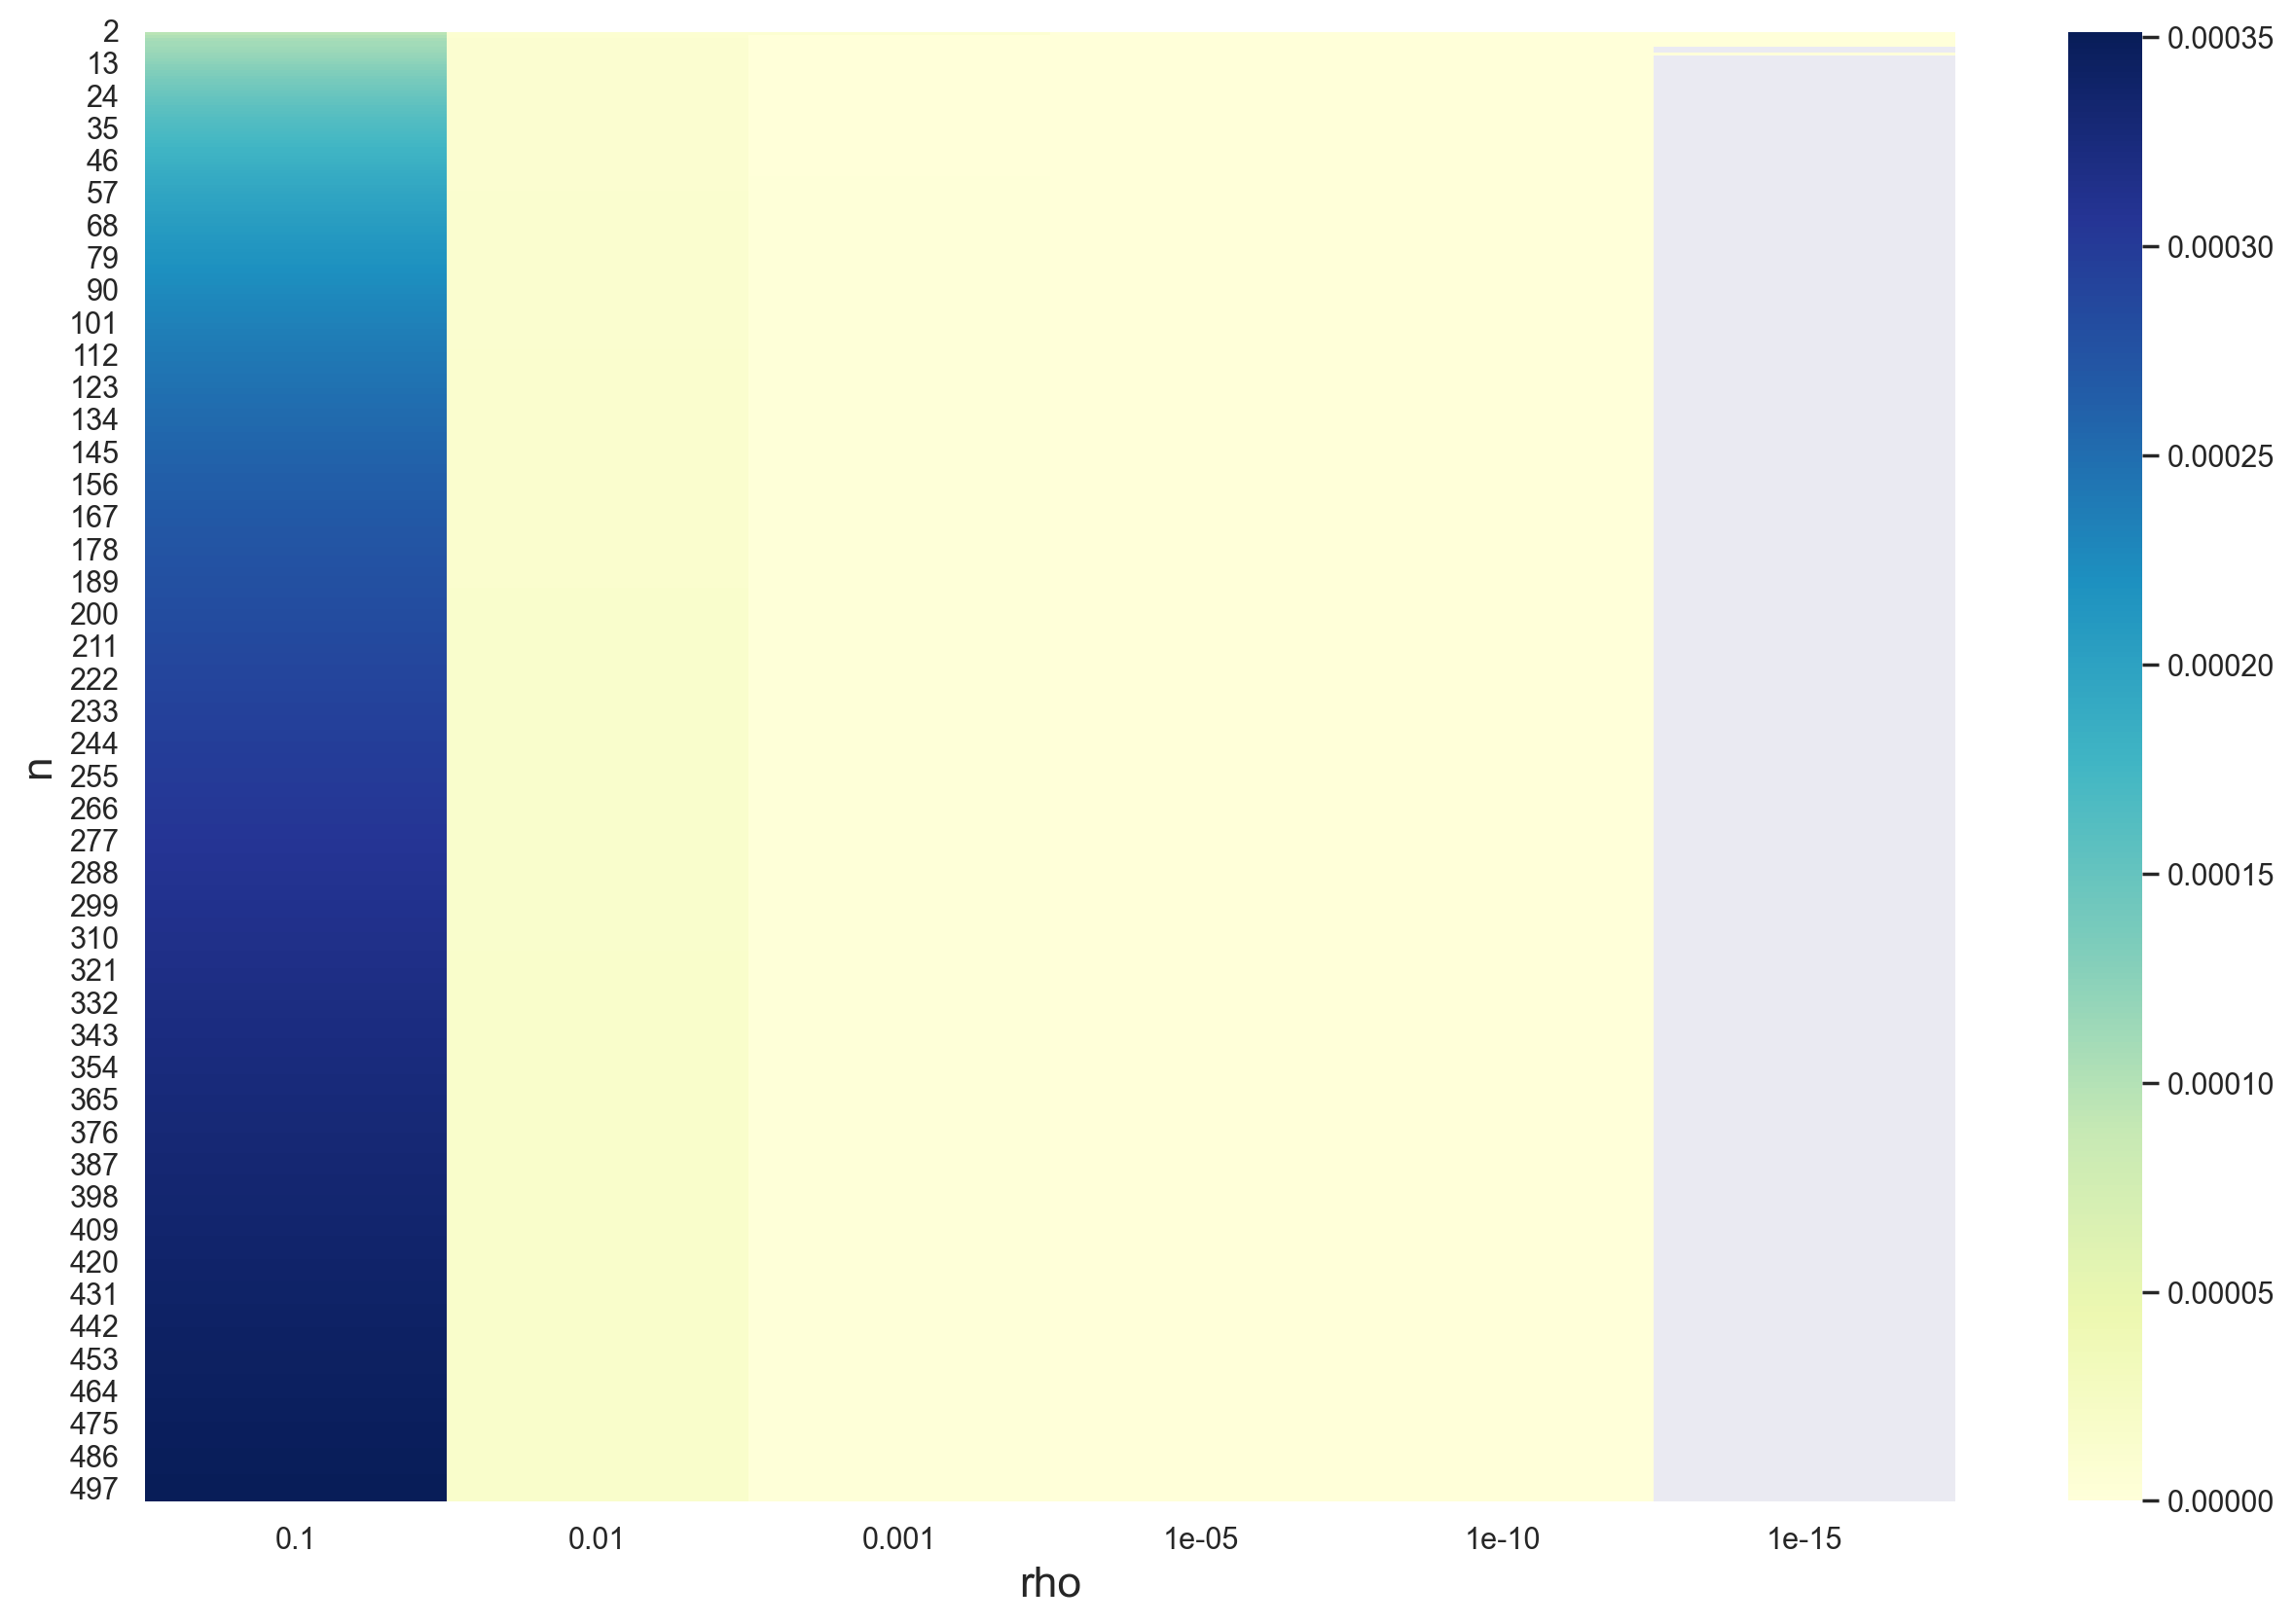

In [55]:
show_heatmap(df_errors2, xlabel='rho', ylabel='n', annot=False)

###### Wykres czasów w skali logarytmicznej

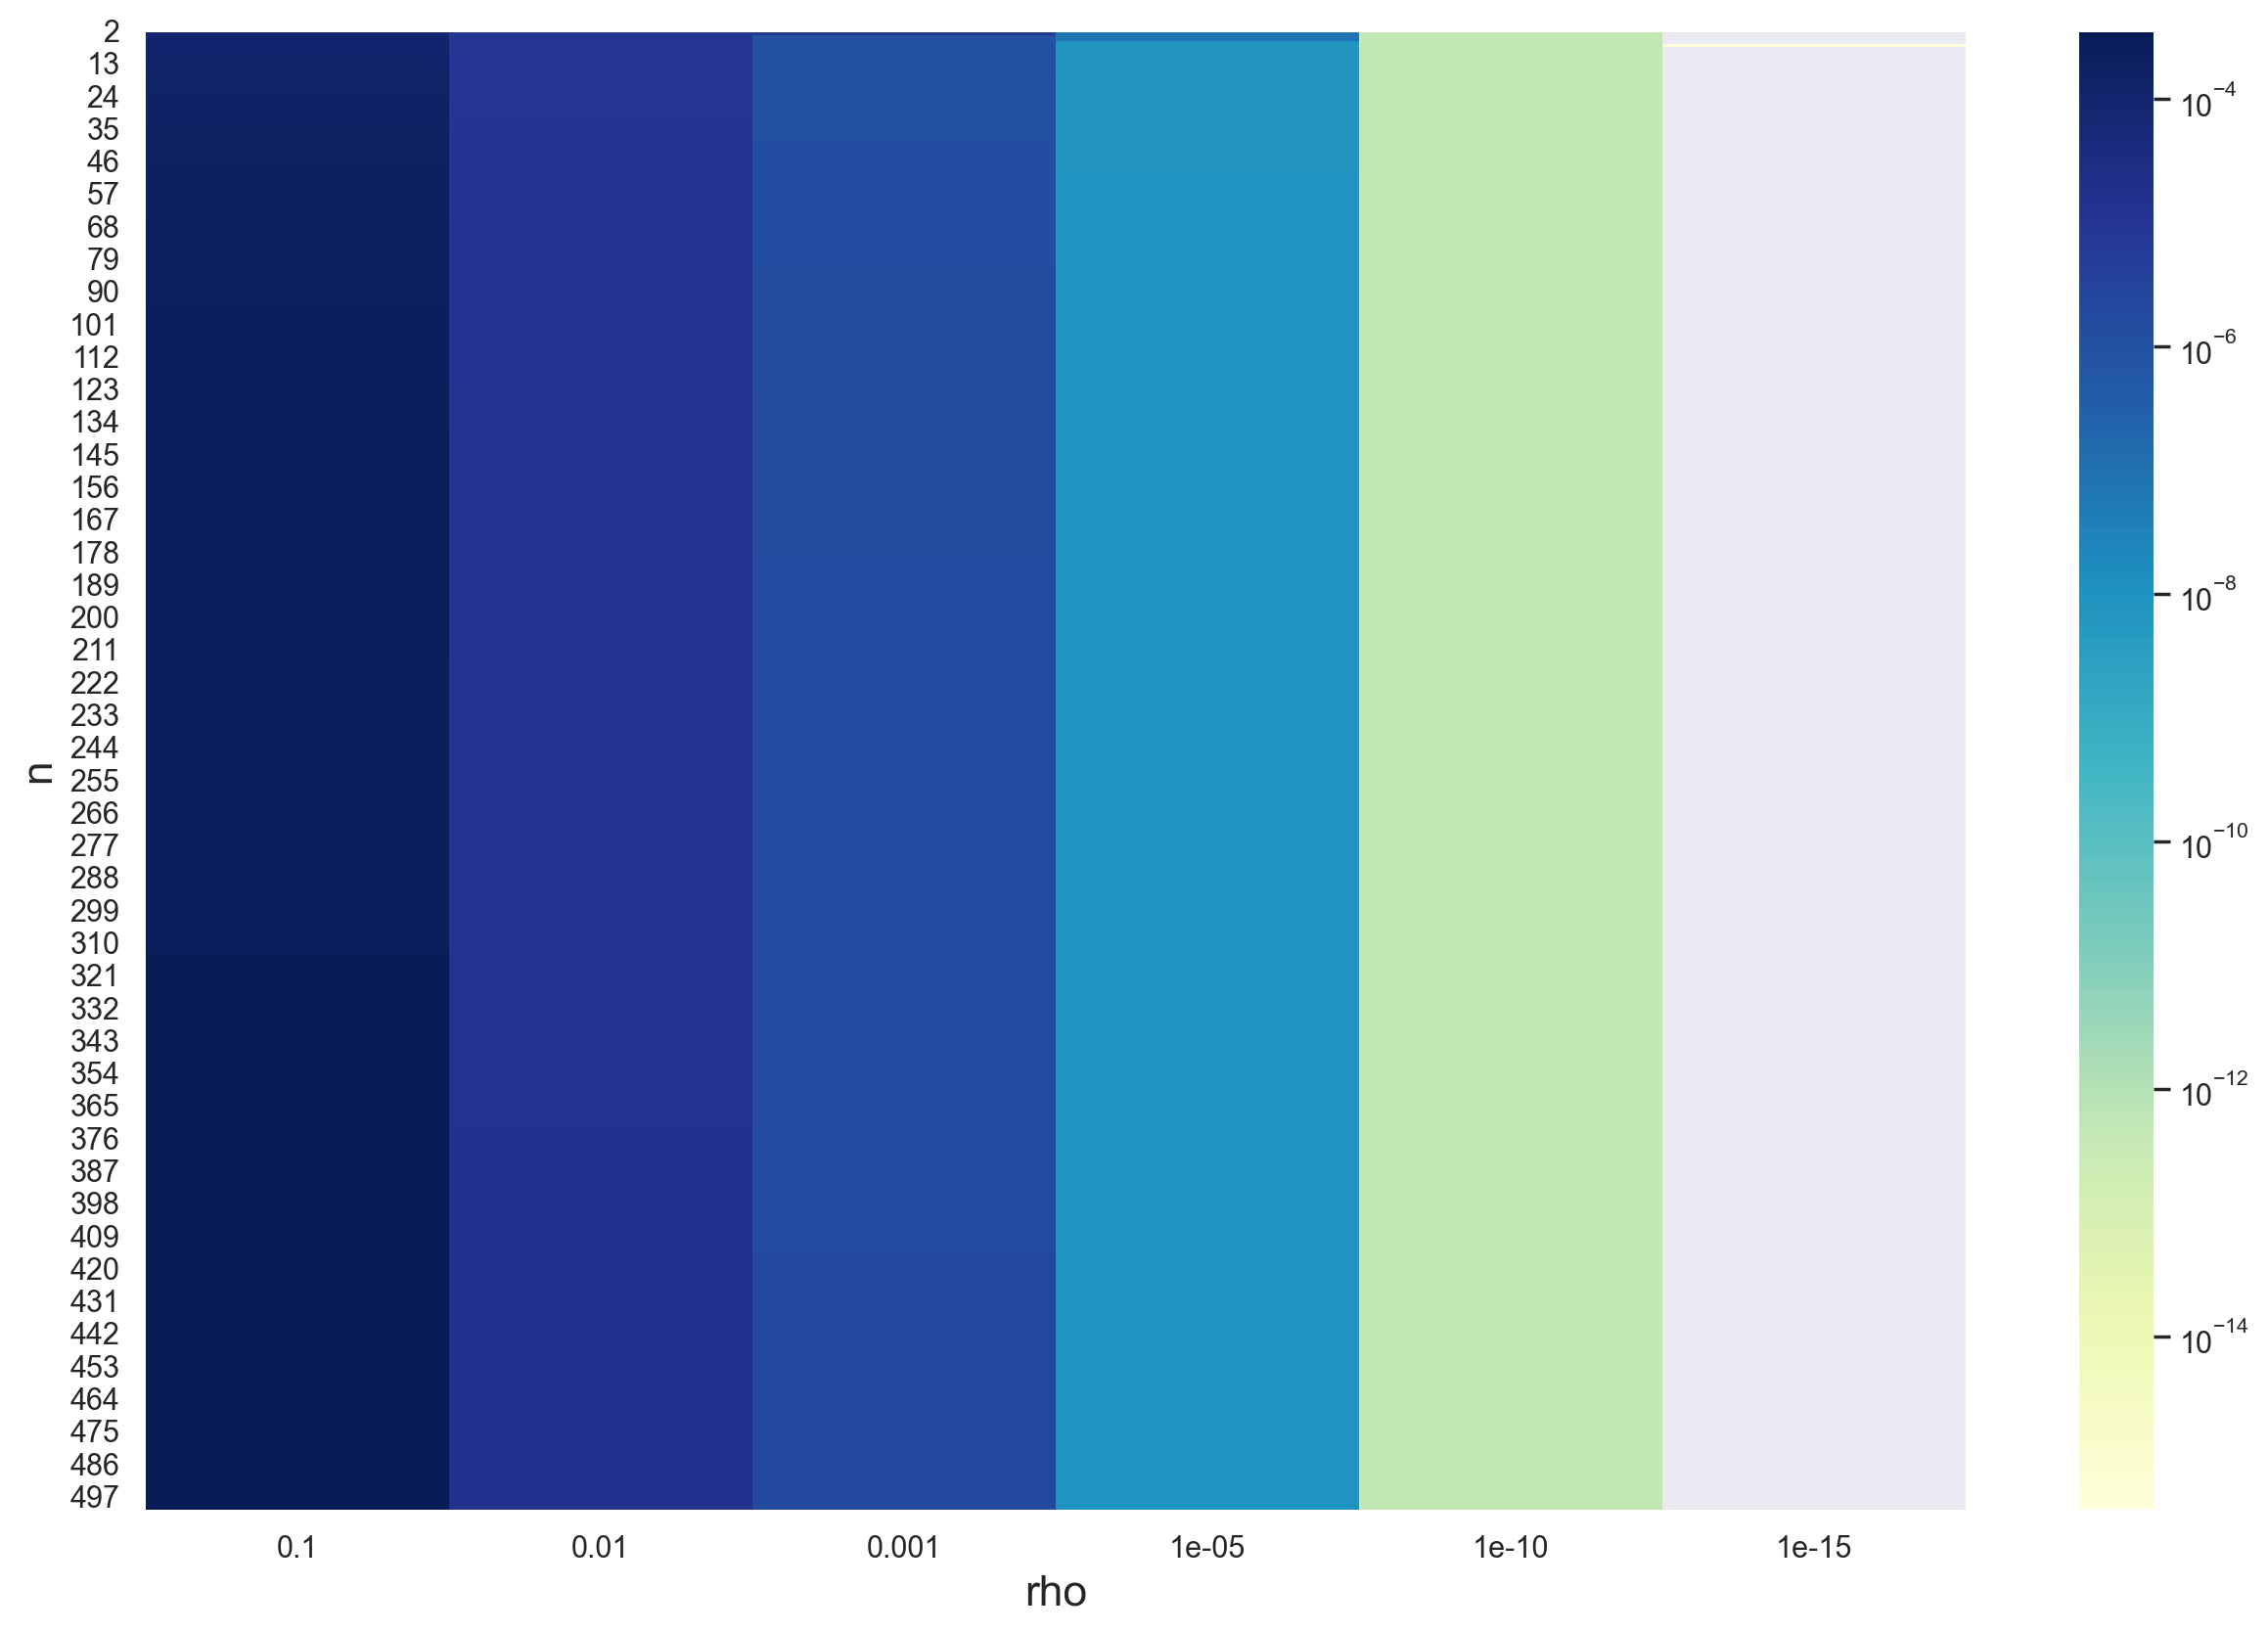

In [56]:
show_heatmap(df_errors2, xlabel='rho', ylabel='n', annot=False, norm=LogNorm())

## Badanie wpływu wektora początkowego na wyniki obliczeń

### Dla 1. kryterium stopu

#### Dla wektora startowego o współrzędnych $10^2$

In [57]:
n_list = list(range(2, 101))
start_vector_fn = lambda _: 10e2
𝜌_list = [1e-1, 1e-2, 1e-3, 1e-5, 1e-10, 1e-15]
stop_criterion = progressive_difference

results = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 99 wartości n
Łączny czas wykonania: 00:00:00.280


##### Liczby iteracji

In [58]:
df_iters = results['iters'].applymap(int)
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,6,6,7,9,14,19
3,5,6,7,8,12,16
4,5,6,7,8,12,16
5,5,6,7,8,13,17
6,5,6,7,8,13,17
...,...,...,...,...,...,...
96,5,6,7,8,13,17
97,5,6,7,8,13,17
98,5,6,7,8,13,17
99,5,6,7,8,13,17


In [59]:
min_n = min(n_list)
interval = 10
ns = [0, *range(interval - min_n, len(n_list), interval)]
df_iters_part = df_iters.iloc[ns]
df_iters_part.to_excel('zad1-start-vec-10pow2-iters1.xlsx')
df_iters_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,6,6,7,9,14,19
10,5,6,7,8,13,17
20,5,6,7,8,13,17
30,5,6,7,8,13,17
40,5,6,7,8,13,17
50,5,6,7,8,13,17
60,5,6,7,8,13,17
70,5,6,7,8,13,17
80,5,6,7,8,13,17
90,5,6,7,8,13,17


##### Czasy obliczeń

In [60]:
df_times = results['times']
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000150,0.000088,0.000467,0.000119,0.000179,0.000239
3,0.000079,0.000088,0.000099,0.000111,0.000157,0.000411
4,0.000117,0.000087,0.000092,0.000163,0.000154,0.000193
5,0.000077,0.000085,0.000096,0.000105,0.000168,0.000202
6,0.000072,0.000081,0.000089,0.000101,0.000158,0.000196
...,...,...,...,...,...,...
96,0.001428,0.000971,0.001071,0.000946,0.001552,0.001960
97,0.000958,0.000676,0.000727,0.000806,0.001286,0.002120
98,0.001451,0.001094,0.000862,0.000863,0.001877,0.002075
99,0.000887,0.000843,0.000985,0.001000,0.001558,0.001925


In [61]:
df_times_part = df_times.iloc[ns]
df_times_part.to_excel('zad1-start-vec-10pow2-times1.xlsx')
df_times_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000150,0.000088,0.000467,0.000119,0.000179,0.000239
10,0.000078,0.000093,0.000106,0.000111,0.000170,0.000215
20,0.000066,0.000073,0.000081,0.000096,0.000136,0.000176
30,0.000097,0.000135,0.000096,0.000096,0.000145,0.000176
40,0.000074,0.000086,0.000087,0.000095,0.000141,0.000180
50,0.000073,0.000077,0.000092,0.000096,0.000146,0.000181
60,0.000084,0.000072,0.000095,0.000088,0.000140,0.000178
70,0.000067,0.000071,0.000078,0.000087,0.000134,0.000166
80,0.000106,0.000089,0.000099,0.000103,0.000165,0.000186
90,0.000117,0.000093,0.000099,0.000108,0.000162,0.000206


##### Błędy obliczeń

In [62]:
df_errors = results['errors']
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000798,0.000798,0.000073,5.997649e-07,3.724026e-12,0.000000e+00
3,0.001205,0.000035,0.000003,3.028212e-07,3.524295e-12,0.000000e+00
4,0.001289,0.000081,0.000006,3.814340e-07,3.595404e-12,0.000000e+00
5,0.001648,0.000094,0.000004,2.399359e-07,2.839823e-13,0.000000e+00
6,0.002024,0.000138,0.000008,3.786558e-07,4.819563e-13,4.002966e-16
...,...,...,...,...,...,...
96,0.001498,0.000078,0.000004,2.628884e-07,2.710105e-13,1.820901e-15
97,0.001460,0.000075,0.000004,2.586612e-07,2.649094e-13,1.820901e-15
98,0.001497,0.000078,0.000004,2.628545e-07,2.708753e-13,1.824283e-15
99,0.001459,0.000075,0.000004,2.587139e-07,2.648608e-13,1.897150e-15


In [63]:
df_errors_part = df_errors.iloc[ns]
df_errors_part.to_excel('zad1-start-vec-10pow2-errors1.xlsx')
df_errors_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000798,0.000798,0.000073,5.997649e-07,3.724026e-12,0.000000e+00
10,0.002026,0.000120,0.000006,3.007895e-07,3.991208e-13,3.330669e-16
20,0.001771,0.000095,0.000005,2.714497e-07,3.111336e-13,4.154074e-16
30,0.001660,0.000088,0.000004,2.670343e-07,2.916252e-13,5.978734e-16
40,0.001603,0.000084,0.000004,2.653473e-07,2.831834e-13,5.324443e-16
50,0.001567,0.000082,0.000004,2.644524e-07,2.789290e-13,7.021667e-16
60,0.001544,0.000080,0.000004,2.638925e-07,2.761898e-13,1.174950e-15
70,0.001526,0.000079,0.000004,2.635056e-07,2.740105e-13,9.420555e-16
80,0.001514,0.000079,0.000004,2.632200e-07,2.725970e-13,1.395529e-15
90,0.001504,0.000078,0.000004,2.629990e-07,2.715393e-13,1.612692e-15


#### Dla wektora startowego o współrzędnych $10^5$

In [64]:
start_vector_fn = lambda _: 10e5
results = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 99 wartości n
Łączny czas wykonania: 00:00:00.336


##### Liczby iteracji

In [65]:
df_iters = results['iters']
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,8,9,10,12,17,22
3,7,8,9,11,15,19
4,7,8,9,11,15,19
5,7,8,9,11,15,19
6,8,8,9,11,15,19
...,...,...,...,...,...,...
96,7,8,9,11,15,19
97,7,8,9,11,15,19
98,7,8,9,11,15,19
99,7,8,9,11,15,19


In [66]:
df_iters_part = df_iters.iloc[ns]
df_iters_part.to_excel('zad1-start-vec-10pow5-iters1.xlsx')
df_iters_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,8,9,10,12,17,22
10,8,8,9,11,15,19
20,7,8,9,11,15,19
30,7,8,9,11,15,19
40,7,8,9,11,15,19
50,7,8,9,11,15,19
60,7,8,9,11,15,19
70,7,8,9,11,15,19
80,7,8,9,11,15,19
90,7,8,9,11,15,19


##### Czasy obliczeń

In [67]:
df_times = results['times']
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000311,0.000170,0.000163,0.000452,0.000305,0.000603
3,0.000145,0.000322,0.000165,0.000184,0.000226,0.000279
4,0.000123,0.000150,0.000120,0.000138,0.000181,0.000306
5,0.000142,0.000135,0.000146,0.000289,0.000294,0.000448
6,0.000268,0.000175,0.000153,0.000173,0.000427,0.000332
...,...,...,...,...,...,...
96,0.001528,0.001423,0.001237,0.001344,0.001548,0.002176
97,0.001043,0.001579,0.001216,0.001283,0.001666,0.002414
98,0.001337,0.001367,0.001211,0.001380,0.001643,0.002516
99,0.001693,0.001150,0.001277,0.001280,0.001590,0.002370


In [68]:
df_times_part = df_times.iloc[ns]
df_times_part.to_excel('zad1-start-vec-10pow5-times1.xlsx')
df_times_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000311,0.000170,0.000163,0.000452,0.000305,0.000603
10,0.000123,0.000110,0.000121,0.000145,0.000188,0.000300
20,0.000111,0.000113,0.000123,0.000145,0.000189,0.000237
30,0.000144,0.000186,0.000178,0.000206,0.000269,0.000317
40,0.000108,0.000161,0.000177,0.000153,0.000198,0.000375
50,0.000187,0.000122,0.000132,0.000155,0.000195,0.000242
60,0.000157,0.000119,0.000128,0.000163,0.000196,0.000242
70,0.000118,0.000120,0.000133,0.000153,0.000197,0.000559
80,0.000117,0.000113,0.000123,0.000145,0.000189,0.000233
90,0.000131,0.000111,0.000122,0.000129,0.000174,0.000207


##### Błędy obliczeń

In [69]:
df_errors = results['errors']
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.006597,0.000600,0.000055,4.506120e-07,2.798062e-12,0.000000e+00
3,0.002954,0.000300,0.000018,2.934443e-08,3.347476e-13,0.000000e+00
4,0.005676,0.000384,0.000024,7.005998e-08,9.498587e-13,0.000000e+00
5,0.004321,0.000239,0.000023,1.233666e-07,2.107113e-12,0.000000e+00
6,0.000381,0.000381,0.000021,1.398729e-07,1.480272e-12,4.154074e-16
...,...,...,...,...,...,...
96,0.003793,0.000261,0.000023,1.063953e-07,1.838563e-12,1.824283e-15
97,0.003681,0.000257,0.000023,1.032292e-07,1.802792e-12,1.820901e-15
98,0.003789,0.000261,0.000023,1.062986e-07,1.838098e-12,1.827658e-15
99,0.003679,0.000257,0.000023,1.031993e-07,1.802822e-12,1.897150e-15


In [70]:
df_errors_part = df_errors.iloc[ns]
df_errors_part.to_excel('zad1-start-vec-10pow5-errors1.xlsx')
df_errors_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.006597,0.000600,0.000055,4.506120e-07,2.798062e-12,0.000000e+00
10,0.000301,0.000301,0.000024,1.463140e-07,1.938397e-12,3.510833e-16
20,0.004631,0.000270,0.000024,1.247593e-07,1.926941e-12,4.154074e-16
30,0.004238,0.000266,0.000024,1.169768e-07,1.895885e-12,5.874748e-16
40,0.004064,0.000264,0.000024,1.130996e-07,1.876749e-12,5.324443e-16
50,0.003966,0.000263,0.000024,1.107871e-07,1.864372e-12,7.364386e-16
60,0.003904,0.000262,0.000024,1.092529e-07,1.855648e-12,1.174950e-15
70,0.003861,0.000262,0.000023,1.081612e-07,1.849536e-12,9.420555e-16
80,0.003829,0.000262,0.000023,1.073449e-07,1.844433e-12,1.395529e-15
90,0.003805,0.000261,0.000023,1.067115e-07,1.840573e-12,1.627907e-15


#### Dla wektora startowego o współrzędnych $10^{20}$

In [71]:
start_vector_fn = lambda _: 10e20
results = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 99 wartości n
Łączny czas wykonania: 00:00:00.528


##### Liczby iteracji

In [72]:
df_iters = results['iters']
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,23,24,25,27,31,36
3,20,20,21,23,27,31
4,20,21,21,23,27,31
5,20,21,22,24,28,32
6,20,21,22,23,28,32
...,...,...,...,...,...,...
96,20,21,22,23,28,32
97,20,21,22,23,28,32
98,20,21,22,23,28,32
99,20,21,22,23,28,32


In [73]:
df_iters_part = df_iters.iloc[ns]
df_iters_part.to_excel('zad1-start-vec-10pow20-iters1.xlsx')
df_iters_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,23,24,25,27,31,36
10,20,21,22,24,28,32
20,20,21,22,24,28,32
30,20,21,22,24,28,32
40,20,21,22,24,28,32
50,20,21,22,24,28,32
60,20,21,22,24,28,32
70,20,21,22,24,28,32
80,20,21,22,23,28,32
90,20,21,22,23,28,32


##### Czasy obliczeń

In [74]:
df_times = results['times']
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.002977,0.000291,0.000310,0.000298,0.000336,0.000444
3,0.000234,0.000223,0.000233,0.000261,0.000301,0.000339
4,0.000236,0.000239,0.000242,0.000262,0.000310,0.000351
5,0.000235,0.000254,0.000254,0.000276,0.000503,0.000372
6,0.000235,0.000258,0.000262,0.000263,0.000331,0.000364
...,...,...,...,...,...,...
96,0.002660,0.003229,0.003192,0.003225,0.004228,0.004411
97,0.002984,0.003132,0.003011,0.004012,0.003554,0.003992
98,0.002586,0.002464,0.002561,0.002680,0.004157,0.003801
99,0.002225,0.002341,0.002955,0.002740,0.003828,0.003802


In [75]:
df_times_part = df_times.iloc[ns]
df_times_part.to_excel('zad1-start-vec-10pow20-times1.xlsx')
df_times_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.002977,0.000291,0.000310,0.000298,0.000336,0.000444
10,0.000272,0.000278,0.000267,0.000286,0.000352,0.000491
20,0.000245,0.000248,0.000299,0.000283,0.000325,0.000389
30,0.000285,0.000262,0.000257,0.000278,0.000329,0.000363
40,0.000246,0.000243,0.000253,0.000291,0.000316,0.000362
50,0.000268,0.000249,0.000251,0.000273,0.000325,0.000362
60,0.000329,0.000270,0.000269,0.000289,0.000346,0.000382
70,0.000344,0.000305,0.000288,0.000307,0.000387,0.000408
80,0.001109,0.000372,0.000335,0.000337,0.000411,0.000469
90,0.000426,0.000344,0.000358,0.000370,0.000439,0.000481


##### Błędy obliczeń

In [76]:
df_errors = results['errors']
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.001579,0.000144,0.000013,1.078729e-07,7.367894e-12,0.000000e+00
3,0.000425,0.000425,0.000044,1.004800e-07,1.727507e-12,0.000000e+00
4,0.000527,0.000033,0.000033,1.563366e-07,1.450529e-12,0.000000e+00
5,0.002218,0.000180,0.000011,2.607543e-08,7.880054e-13,0.000000e+00
6,0.001479,0.000108,0.000009,6.563340e-07,6.490689e-13,4.002966e-16
...,...,...,...,...,...,...
96,0.001756,0.000142,0.000009,5.036258e-07,6.685069e-13,1.820901e-15
97,0.001728,0.000139,0.000009,4.869033e-07,6.491605e-13,1.820901e-15
98,0.001756,0.000142,0.000009,5.030691e-07,6.680922e-13,1.824283e-15
99,0.001729,0.000139,0.000009,4.867052e-07,6.492119e-13,1.897150e-15


In [77]:
df_errors = df_errors.iloc[ns]
df_errors.to_excel('zad1-start-vec-10pow20-errors1.xlsx')
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.001579,0.000144,0.000013,1.078729e-07,7.367894e-12,0.000000e+00
10,0.001765,0.000157,0.000012,3.900750e-08,9.073733e-13,3.330669e-16
20,0.001777,0.000152,0.000011,2.936779e-08,7.797374e-13,4.154074e-16
30,0.001772,0.000148,0.000010,2.678202e-08,7.328917e-13,6.377746e-16
40,0.001768,0.000146,0.000010,2.561790e-08,7.094777e-13,5.324443e-16
50,0.001764,0.000145,0.000010,2.496038e-08,6.955093e-13,7.021667e-16
60,0.001762,0.000144,0.000010,2.453896e-08,6.861763e-13,1.174950e-15
70,0.001760,0.000143,0.000010,2.424619e-08,6.794222e-13,9.420555e-16
80,0.001758,0.000143,0.000009,5.091043e-07,6.744833e-13,1.391105e-15
90,0.001757,0.000143,0.000009,5.054474e-07,6.706775e-13,1.612692e-15


#### Dla ustalonej wartości $n$

##### Obliczenia

In [78]:
n = 100
𝜌_list = [1e-1, 1e-2, 1e-3, 1e-5, 1e-10, 1e-15]
stop_criterion = progressive_difference
start_vector_values = list(map(lambda exp: 10 ** exp, range(21)))
results = {
    'iters': [],
    'times': [],
    'errors': [],
    'vectors': []
}

for a in start_vector_values:
    result = calculate([n], 𝜌_list, lambda _: a, stop_criterion)
    for key, val in result.items():
        results[key].append(list(val.iloc[0]))

Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n


##### Liczby iteracji w zależności od wartości współrzędnych wektora początkowego oraz $\rho$

In [79]:
df_iters = pd.DataFrame(results['iters'], index=start_vector_values, columns=𝜌_list)
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
1,3,4,5,7,11,16
10,4,4,5,7,11,16
100,4,5,6,7,12,16
1000,5,6,7,8,13,17
10000,6,7,7,9,13,18
100000,7,7,8,10,14,18
1000000,7,8,9,11,15,19
10000000,8,9,10,12,16,20
100000000,9,10,11,13,17,21
1000000000,10,11,12,13,18,22


In [80]:
df_iters.to_excel('zad1-start-vec-const-n-iters1.xlsx')

##### Czasy obliczeń w zależności od wartości współrzędnych wektora początkowego oraz $\rho$

In [81]:
df_times = pd.DataFrame(results['times'], index=start_vector_values, columns=𝜌_list)
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
1,0.000932,0.000715,0.001395,0.001681,0.001900,0.002403
10,0.001454,0.000637,0.000784,0.000977,0.001599,0.002353
100,0.000809,0.000715,0.000915,0.000993,0.001878,0.002271
1000,0.001073,0.001110,0.001128,0.001332,0.001746,0.002299
10000,0.001354,0.001024,0.001192,0.001567,0.002014,0.002655
100000,0.001527,0.000946,0.001096,0.001403,0.002048,0.002763
1000000,0.001491,0.001172,0.001222,0.001587,0.002115,0.002703
10000000,0.001643,0.001188,0.001434,0.001558,0.001893,0.002849
100000000,0.001403,0.001236,0.001459,0.001727,0.001953,0.002398
1000000000,0.001791,0.001809,0.001575,0.001539,0.002522,0.002820


In [82]:
df_times.to_excel('zad1-start-vec-const-n-times1.xlsx')

##### Błędy obliczeń w zależności od wartości współrzędnych wektora początkowego oraz $\rho$

In [83]:
df_errors = pd.DataFrame(results['errors'], index=start_vector_values, columns=𝜌_list)
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
1,0.002146,0.000218,0.000011,8.014370e-08,6.143344e-12,1.518207e-15
10,0.000165,0.000165,0.000014,7.888042e-08,5.766105e-12,1.518207e-15
100,0.001984,0.000144,0.000007,3.632005e-07,7.922295e-13,1.518207e-15
1000,0.001495,0.000078,0.000004,2.628219e-07,2.707491e-13,1.514142e-15
10000,0.000785,0.000038,0.000038,2.331289e-07,2.665917e-12,1.514142e-15
100000,0.000379,0.000379,0.000026,1.746349e-07,2.148803e-12,1.514142e-15
1000000,0.003786,0.000261,0.000023,1.062057e-07,1.837693e-12,1.514142e-15
10000000,0.002613,0.000233,0.000017,5.300473e-08,1.293183e-12,1.514142e-15
100000000,0.002335,0.000175,0.000011,2.665686e-08,7.376605e-13,1.514142e-15
1000000000,0.001746,0.000106,0.000005,2.665686e-07,3.524571e-13,1.514142e-15


In [84]:
df_errors.to_excel('zad1-start-vec-const-n-errors1.xlsx')

### Dla 2. kryterium stopu

#### Dla wektora startowego o współrzędnych $10^2$

In [120]:
n_list = list(range(2, 101))
start_vector_fn = lambda _: 10e2
𝜌_list = [1e-1, 1e-2, 1e-3, 1e-5, 1e-10, 1e-15]
stop_criterion = solution_difference

results = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 99 wartości n
Łączny czas wykonania: 00:00:02.304


##### Liczby iteracji

In [124]:
df_iters = results['iters'].replace(-1, '-')
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,7,7,8,10,15,20
3,6,7,7,9,13,17
4,6,7,7,9,13,17
5,6,7,8,9,13,18
6,6,7,8,9,14,18
...,...,...,...,...,...,...
96,6,7,7,9,13,-
97,6,7,7,9,13,-
98,6,7,7,9,13,-
99,6,7,7,9,13,-


In [125]:
min_n = min(n_list)
interval = 10
ns = [0, *range(interval - min_n, len(n_list), interval)]
df_iters_part = df_iters.iloc[ns]
df_iters_part.to_excel('zad1-start-vec-10pow2-iters2.xlsx')
df_iters_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,7,7,8,10,15,20
10,6,7,8,9,13,-
20,6,7,8,9,13,-
30,6,7,8,9,13,-
40,6,7,7,9,13,-
50,6,7,7,9,13,-
60,6,7,7,9,13,-
70,6,7,7,9,13,-
80,6,7,7,9,13,-
90,6,7,7,9,13,-


##### Czasy obliczeń

In [127]:
df_times = results['times'].replace(np.nan, '-')
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000325,0.000258,0.000176,0.000254,0.000195,0.000261
3,0.000088,0.000092,0.000101,0.000149,0.000172,0.000202
4,0.000085,0.000093,0.000094,0.000122,0.000161,0.000237
5,0.000087,0.000094,0.000104,0.000115,0.000193,0.000244
6,0.000095,0.000103,0.000118,0.000126,0.000194,0.000233
...,...,...,...,...,...,...
96,0.001671,0.001782,0.001739,0.001930,0.002423,-
97,0.002439,0.001745,0.001542,0.001919,0.002957,-
98,0.001851,0.001928,0.001344,0.001621,0.002732,-
99,0.001351,0.001548,0.001547,0.001830,0.002390,-


In [128]:
df_times_part = df_times.iloc[ns]
df_times_part.to_excel('zad1-start-vec-10pow2-times2.xlsx')
df_times_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000325,0.000258,0.000176,0.000254,0.000195,0.000261
10,0.000068,0.000074,0.000083,0.000092,0.000131,-
20,0.000086,0.000077,0.000086,0.000095,0.000130,-
30,0.000112,0.000086,0.000090,0.000103,0.000135,-
40,0.000104,0.000082,0.000082,0.000098,0.000144,-
50,0.000157,0.000098,0.000096,0.000117,0.000167,-
60,0.000190,0.000112,0.000109,0.000148,0.000189,-
70,0.000170,0.000121,0.000107,0.000136,0.000179,-
80,0.000191,0.000114,0.000113,0.000138,0.000188,-
90,0.000176,0.000108,0.000106,0.000126,0.000173,-


##### Błędy obliczeń

In [129]:
df_errors = results['errors'].replace(np.nan, '-')
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000073,0.000073,6.597414e-06,5.452408e-08,3.385907e-13,0.0
3,0.000035,0.000003,2.945191e-06,1.794955e-08,2.768931e-13,0.0
4,0.000081,0.000006,5.705430e-06,2.410124e-08,1.952411e-13,0.0
5,0.000094,0.000004,2.399359e-07,2.257811e-08,2.839823e-13,0.0
6,0.000138,0.000008,3.786558e-07,2.084014e-08,2.442011e-14,0.0
...,...,...,...,...,...,...
96,0.000078,0.000004,3.770365e-06,2.303632e-08,2.710105e-13,-
97,0.000075,0.000004,3.658174e-06,2.262879e-08,2.649094e-13,-
98,0.000078,0.000004,3.766524e-06,2.303027e-08,2.708753e-13,-
99,0.000075,0.000004,3.656815e-06,2.263084e-08,2.648608e-13,-


In [130]:
df_errors_part = df_errors.iloc[ns]
df_errors_part.to_excel('zad1-start-vec-10pow2-errors2.xlsx')
df_errors_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000073,0.000073,6.597414e-06,5.452408e-08,3.385907e-13,0.0
10,0.000120,0.000006,3.007895e-07,2.356492e-08,3.991208e-13,-
20,0.000095,0.000005,2.714497e-07,2.379568e-08,3.111336e-13,-
30,0.000088,0.000004,2.670343e-07,2.356144e-08,2.916252e-13,-
40,0.000084,0.000004,4.050186e-06,2.339702e-08,2.831834e-13,-
50,0.000082,0.000004,3.950127e-06,2.328417e-08,2.789290e-13,-
60,0.000080,0.000004,3.885945e-06,2.320296e-08,2.761898e-13,-
70,0.000079,0.000004,3.841241e-06,2.314185e-08,2.740105e-13,-
80,0.000079,0.000004,3.808280e-06,2.309417e-08,2.725970e-13,-
90,0.000078,0.000004,3.782945e-06,2.305589e-08,2.715393e-13,-


#### Dla wektora startowego o współrzędnych $10^5$

In [131]:
start_vector_fn = lambda _: 10e5
results = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 99 wartości n
Łączny czas wykonania: 00:00:02.198


##### Liczby iteracji

In [132]:
df_iters = results['iters'].replace(-1, '-')
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,9,10,11,13,18,23
3,8,9,10,11,16,19
4,8,9,10,12,16,20
5,8,9,10,12,16,20
6,8,9,10,12,16,21
...,...,...,...,...,...,...
96,8,9,10,12,16,-
97,8,9,10,12,16,-
98,8,9,10,12,16,-
99,8,9,10,12,16,-


In [133]:
df_iters_part = df_iters.iloc[ns]
df_iters_part.to_excel('zad1-start-vec-10pow5-iters2.xlsx')
df_iters_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,9,10,11,13,18,23
10,8,9,10,12,16,-
20,8,9,10,12,16,-
30,8,9,10,12,16,-
40,8,9,10,12,16,-
50,8,9,10,12,16,-
60,8,9,10,12,16,-
70,8,9,10,12,16,-
80,8,9,10,12,16,-
90,8,9,10,12,16,-


##### Czasy obliczeń

In [134]:
df_times = results['times'].replace(np.nan, '-')
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000184,0.000256,0.000264,0.000362,0.000536,0.000282
3,0.000109,0.000119,0.000111,0.000113,0.000156,0.000178
4,0.000085,0.000092,0.000099,0.000117,0.000158,0.000189
5,0.000085,0.000093,0.000100,0.000117,0.000152,0.000197
6,0.000090,0.000091,0.000100,0.000119,0.000153,0.000198
...,...,...,...,...,...,...
96,0.001991,0.001975,0.001873,0.001912,0.003750,-
97,0.001786,0.001637,0.001655,0.002509,0.002649,-
98,0.001734,0.001490,0.001698,0.002296,0.003047,-
99,0.002428,0.001740,0.001934,0.002146,0.002939,-


In [135]:
df_times_part = df_times.iloc[ns]
df_times_part.to_excel('zad1-start-vec-10pow5-times2.xlsx')
df_times_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000184,0.000256,0.000264,0.000362,0.000536,0.000282
10,0.000097,0.000103,0.000102,0.000118,0.000154,-
20,0.000106,0.000104,0.000106,0.000120,0.000154,-
30,0.000177,0.000109,0.000116,0.000138,0.000175,-
40,0.000127,0.000101,0.000109,0.000126,0.000165,-
50,0.000139,0.000103,0.000113,0.000132,0.000169,-
60,0.000208,0.000136,0.000163,0.000150,0.000192,-
70,0.000181,0.000124,0.000136,0.000151,0.000201,-
80,0.000151,0.000116,0.000123,0.000156,0.000184,-
90,0.000423,0.000354,0.000368,0.000193,0.000231,-


##### Błędy obliczeń

In [136]:
df_errors = results['errors'].replace(np.nan, '-')
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000600,0.000055,4.956732e-06,4.096473e-08,2.543550e-13,0.0
3,0.000300,0.000018,6.529874e-07,2.934443e-08,4.068282e-14,0.0
4,0.000384,0.000024,1.349334e-06,3.541676e-09,6.184052e-14,0.0
5,0.000239,0.000023,1.901799e-06,6.230322e-09,1.530716e-13,0.0
6,0.000381,0.000021,1.745609e-06,9.216521e-09,1.274978e-13,0.0
...,...,...,...,...,...,...
96,0.000261,0.000023,1.748113e-06,5.312870e-09,1.296638e-13,-
97,0.000257,0.000023,1.706451e-06,5.129449e-09,1.263062e-13,-
98,0.000261,0.000023,1.747140e-06,5.306582e-09,1.295199e-13,-
99,0.000257,0.000023,1.706335e-06,5.127135e-09,1.264357e-13,-


In [137]:
df_errors_part = df_errors.iloc[ns]
df_errors_part.to_excel('zad1-start-vec-10pow5-errors2.xlsx')
df_errors_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000600,0.000055,0.000005,4.096473e-08,2.543550e-13,0.0
10,0.000301,0.000024,0.000002,8.478004e-09,1.590784e-13,-
20,0.000270,0.000024,0.000002,6.602549e-09,1.452360e-13,-
30,0.000266,0.000024,0.000002,6.031557e-09,1.387482e-13,-
40,0.000264,0.000024,0.000002,5.760974e-09,1.354417e-13,-
50,0.000263,0.000024,0.000002,5.603644e-09,1.336526e-13,-
60,0.000262,0.000024,0.000002,5.500888e-09,1.322611e-13,-
70,0.000262,0.000023,0.000002,5.428544e-09,1.314047e-13,-
80,0.000262,0.000023,0.000002,5.374865e-09,1.302343e-13,-
90,0.000261,0.000023,0.000002,5.333459e-09,1.300078e-13,-


#### Dla wektora startowego o współrzędnych $10^{20}$

In [138]:
start_vector_fn = lambda _: 10e20
results = calculate(n_list, 𝜌_list, start_vector_fn, stop_criterion)
print_duration(times['total'])

Obliczono układy równań dla 25 wartości n
Obliczono układy równań dla 50 wartości n
Obliczono układy równań dla 75 wartości n
Obliczono układy równań dla 99 wartości n
Łączny czas wykonania: 00:00:02.481


##### Liczby iteracji

In [140]:
df_iters = results['iters'].replace(-1, '-')
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,24,25,26,28,32,37
3,20,21,22,24,28,32
4,21,21,22,24,28,32
5,21,22,23,24,29,33
6,21,22,23,24,28,33
...,...,...,...,...,...,...
96,21,22,23,24,29,-
97,21,22,23,24,29,-
98,21,22,23,24,29,-
99,21,22,23,24,29,-


In [141]:
df_iters_part = df_iters.iloc[ns]
df_iters_part.to_excel('zad1-start-vec-10pow20-iters2.xlsx')
df_iters_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,24,25,26,28,32,37
10,21,22,23,24,29,-
20,21,22,23,24,29,-
30,21,22,23,24,29,-
40,21,22,23,24,29,-
50,21,22,23,24,29,-
60,21,22,23,24,29,-
70,21,22,23,24,29,-
80,21,22,23,24,29,-
90,21,22,23,24,29,-


##### Czasy obliczeń

In [142]:
df_times = results['times'].replace(np.nan, '-')
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000351,0.000557,0.000300,0.000321,0.000355,0.000411
3,0.000247,0.000251,0.000262,0.000287,0.000333,0.000368
4,0.000246,0.000245,0.000249,0.000279,0.000319,0.000389
5,0.000253,0.000262,0.000272,0.000283,0.000340,0.000395
6,0.000258,0.000265,0.000362,0.000301,0.000318,0.000407
...,...,...,...,...,...,...
96,0.005460,0.004275,0.004619,0.004768,0.005946,-
97,0.004472,0.004222,0.004013,0.004674,0.005415,-
98,0.004414,0.005291,0.005089,0.005055,0.005964,-
99,0.005230,0.004279,0.004726,0.005241,0.006326,-


In [143]:
df_times_part = df_times.iloc[ns]
df_times_part.to_excel('zad1-start-vec-10pow20-times2.xlsx')
df_times_part

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000351,0.000557,0.000300,0.000321,0.000355,0.000411
10,0.000293,0.000295,0.000357,0.000341,0.000399,-
20,0.000237,0.000210,0.000223,0.000234,0.000272,-
30,0.000242,0.000220,0.000238,0.000236,0.000284,-
40,0.000251,0.000220,0.000227,0.000305,0.000299,-
50,0.000255,0.000229,0.000254,0.000266,0.000320,-
60,0.000261,0.000492,0.000698,0.000422,0.000449,-
70,0.000285,0.000258,0.000252,0.000261,0.000311,-
80,0.000531,0.000344,0.000355,0.000320,0.000342,-
90,0.000549,0.000540,0.000339,0.000340,0.000619,-


##### Błędy obliczeń

In [144]:
df_errors = results['errors'].replace(np.nan, '-')
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000144,0.000013,1.186602e-06,9.806631e-09,6.698014e-13,0.0
3,0.000425,0.000044,2.729969e-06,4.223568e-09,5.001231e-14,0.0
4,0.000033,0.000033,2.303541e-06,9.741809e-09,8.199356e-14,0.0
5,0.000180,0.000011,5.620216e-07,2.607543e-08,3.525723e-14,0.0
6,0.000108,0.000009,6.563340e-07,3.838507e-08,6.490689e-13,0.0
...,...,...,...,...,...,...
96,0.000142,0.000009,5.036258e-07,2.378500e-08,3.376119e-14,-
97,0.000139,0.000009,4.869033e-07,2.302629e-08,3.267849e-14,-
98,0.000142,0.000009,5.030691e-07,2.376018e-08,3.373452e-14,-
99,0.000139,0.000009,4.867052e-07,2.301820e-08,3.266075e-14,-


In [145]:
df_errors = df_errors.iloc[ns]
df_errors.to_excel('zad1-start-vec-10pow20-errors2.xlsx')
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
2,0.000144,0.000013,1.186602e-06,9.806631e-09,6.698014e-13,0.0
10,0.000157,0.000012,7.623214e-07,3.900750e-08,5.354763e-14,-
20,0.000152,0.000011,6.140811e-07,2.936779e-08,4.173937e-14,-
30,0.000148,0.000010,5.660461e-07,2.678202e-08,3.816907e-14,-
40,0.000146,0.000010,5.428153e-07,2.561790e-08,3.644289e-14,-
50,0.000145,0.000010,5.291615e-07,2.496038e-08,3.541716e-14,-
60,0.000144,0.000010,5.201833e-07,2.453896e-08,3.473614e-14,-
70,0.000143,0.000010,5.138326e-07,2.424619e-08,3.443016e-14,-
80,0.000143,0.000009,5.091043e-07,2.403110e-08,3.420604e-14,-
90,0.000143,0.000009,5.054474e-07,2.386646e-08,3.396031e-14,-


#### Dla ustalonej wartości $n$

##### Obliczenia

In [146]:
n = 100
𝜌_list = [1e-1, 1e-2, 1e-3, 1e-5, 1e-10, 1e-15]
stop_criterion = solution_difference
start_vector_values = list(map(lambda exp: 10 ** exp, range(21)))
results = {
    'iters': [],
    'times': [],
    'errors': [],
    'vectors': []
}

for a in start_vector_values:
    result = calculate([n], 𝜌_list, lambda _: a, stop_criterion)
    for key, val in result.items():
        results[key].append(list(val.iloc[0]))

Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n
Obliczono układy równań dla 1 wartości n


##### Liczby iteracji w zależności od wartości współrzędnych wektora początkowego oraz $\rho$

In [107]:
df_iters = pd.DataFrame(results['iters'], index=start_vector_values, columns=𝜌_list).replace(-1, '-')
df_iters

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
1,4,5,6,8,12,-
10,4,5,6,8,12,-
100,5,6,7,8,13,-
1000,6,7,7,9,13,-
10000,7,7,8,10,14,-
100000,7,8,9,11,15,-
1000000,8,9,10,12,16,-
10000000,9,10,11,13,17,-
100000000,10,11,12,13,18,-
1000000000,11,12,13,14,18,-


In [108]:
df_iters.to_excel('zad1-start-vec-const-n-iters2.xlsx')

##### Czasy obliczeń w zależności od wartości współrzędnych wektora początkowego oraz $\rho$

In [109]:
df_times = pd.DataFrame(results['times'], index=start_vector_values, columns=𝜌_list).replace(np.nan, '-')
df_times

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
1,0.001889,0.001737,0.001684,0.002035,0.003186,-
10,0.001550,0.001559,0.001517,0.002197,0.002995,-
100,0.001780,0.001591,0.001777,0.001880,0.003073,-
1000,0.001975,0.001673,0.001818,0.002362,0.002960,-
10000,0.002311,0.002271,0.001673,0.002827,0.003184,-
100000,0.001987,0.001556,0.002145,0.002375,0.002576,-
1000000,0.001792,0.002349,0.002877,0.002518,0.003944,-
10000000,0.002409,0.002743,0.002546,0.002824,0.004437,-
100000000,0.002608,0.002398,0.002146,0.003427,0.003646,-
1000000000,0.002765,0.002465,0.002778,0.002443,0.003650,-


In [110]:
df_times.to_excel('zad1-start-vec-const-n-times2.xlsx')

##### Błędy obliczeń w zależności od wartości współrzędnych wektora początkowego oraz $\rho$

In [111]:
df_errors = pd.DataFrame(results['errors'], index=start_vector_values, columns=𝜌_list).replace(np.nan, '-')
df_errors

,1.000000e-01,1.000000e-02,1.000000e-03,1.000000e-05,1.000000e-10,1.000000e-15
1,0.000218,0.000011,1.457352e-06,8.632697e-09,5.039670e-13,-
10,0.000165,0.000014,1.118093e-06,9.366241e-09,5.149309e-13,-
100,0.000144,0.000007,3.632005e-07,2.877816e-08,5.555410e-14,-
1000,0.000078,0.000004,3.762842e-06,2.302443e-08,2.707491e-13,-
10000,0.000038,0.000038,2.614538e-06,1.747789e-08,2.136114e-13,-
100000,0.000379,0.000026,2.334254e-06,1.061793e-08,1.838749e-13,-
1000000,0.000261,0.000023,1.746206e-06,5.300552e-09,1.293456e-13,-
10000000,0.000233,0.000017,1.062084e-06,2.665686e-09,7.365976e-14,-
100000000,0.000175,0.000011,5.300465e-07,2.665686e-08,3.531801e-14,-
1000000000,0.000106,0.000005,2.665686e-07,2.150025e-08,3.524571e-13,-


In [112]:
df_errors.to_excel('zad1-start-vec-const-n-errors2.xlsx')

# Zadanie 2

## Opis zadania

Dowolną metodą znajdź promień spektralny macierzy iteracji (dla różnych rozmiarów układu – 
takich, dla których znajdowane były rozwiązania układu). Sprawdź, czy spełnione są założenia o 
zbieżności metody dla zadanego układu.

Opisz metodę znajdowania promienia spektralnego.

*Promień spektralny macierzy - wartość własna o maksymalnej wartości bezwzględnej.*

## Sposób wyznaczania promienia spektralnego macierzy iteracji $M$

1) Mamy do rozwiązania:

$A \cdot x = b$

gdzie $A$ jest macierzą $n \times n$,
- $x$ – wektor $n$ niewiadomych,
- $b$ – wektor danych (źródeł).

<br>

2) Zapisujemy macierz $A$ w postaci sumy macierzy:

$A = B + R$

gdzie:
- $B$ – macierz dla, której łatwo wyznaczyć $B^{-1}$ (np. może to być macierz diagonalna),
- $R$ – pozostała część macierzy $A$.

Otrzymujemy:

$A \cdot x = (B + R) \cdot x = b$

$B \cdot x = −R \cdot x + b$

$B \cdot x = −(A − B) \cdot x + b$

<br>

3) Wyznaczone w poprzednim punkcie równanie możemy zapisać w postaci iteracyjnej:

$B \cdot x^{(t + 1)} = -(A - B) \cdot x^{(t)} + b$

$x^{(t + 1)} = -B^{-1} \cdot (A - B) \cdot x^{(t)} + B^{-1} \cdot b$

$x^{(t + 1)} = I - B^{-1} \cdot A \cdot x^{(t)} + B^{-1} \cdot b$

$ I - B^{-1} \cdot A $ jest macierzą iteracji $M$

4) Promień spektralny wyznaczam jako wartość własną o maksymalnej wartości bezwzględnej. Do wyznaczenia wartości własnych wykorzystuję funkcję `linalg.eig` z biblioteki `numpy`.

### Przykład

In [113]:
n = 5
A = create_A_matrix(n)
B = np.diagflat(np.diag(A))
I = np.eye(n)

M = I - np.linalg.inv(B) @ A
M

array([[ 0.        , -0.09090909,  0.06060606, -0.04545455,  0.03636364],
       [-0.09090909,  0.        ,  0.06060606, -0.04545455,  0.03636364],
       [ 0.        , -0.06060606,  0.        , -0.04545455,  0.03636364],
       [ 0.        ,  0.        , -0.04545455,  0.        ,  0.03636364],
       [ 0.        ,  0.        ,  0.        , -0.03636364,  0.        ]])

In [114]:
max(abs(np.linalg.eigvals(M)))

0.09090909090909104

## Rezultaty

##### Pomocnicza funkcja, służąca do wyznaczania promienia spektralnego macierzy iteracji dla zadanego $n$

In [115]:
def spectral_radius(n):
    A = create_A_matrix(n)
    B = np.diagflat(np.diag(A))
    I = np.eye(n)

    M = I - np.linalg.inv(B) @ A
    return max(abs(np.linalg.eigvals(M)))

##### Wyniki

In [116]:
min_n = 2
max_n = 500
sr_list = list(map(spectral_radius, range(min_n, max_n + 1)))

Widzimy, że wszystkie promienie spektralne spełniają warunek zbieżności.

In [117]:
all(p < 1 for p in sr_list)

True

In [118]:
df_sr = pd.DataFrame(sr_list, index=list(range(min_n, max_n + 1)), columns=['promień spektralny'])
df_sr

,promień spektralny
2,0.090909
3,0.090909
4,0.090909
5,0.090909
6,0.090909
...,...
496,0.090909
497,0.090909
498,0.090909
499,0.090909


In [119]:
interval = 10
df_sr_part = df_sr[interval-min_n::interval]
df_sr_part.to_excel('spectral-radius.xlsx')
df_sr_part

,promień spektralny
10,0.090909
20,0.090909
30,0.090909
40,0.090909
50,0.090909
60,0.090909
70,0.090909
80,0.090909
90,0.090909
100,0.090909
